In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn

from train_evaluate import NMR_prediction
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import torch.nn as nn
from dgl import AddSelfLoop
from model_zoo.NMR_gcn import NMR_GCN
from create_graph_data_experiment import create_graph_experiment
from node_embeddings_experiment import create_node_embeddings
from create_adjaency_matrix_from_labeled_pdb import build_adjacency_matrix
from tqdm import tqdm

In [2]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_colwidth', None)


In [3]:
num_test = 60
atom_dim=256

residual_dim=128

mono_dim=64
ab_dim = 64
dl_dim = 64
pf_dim = 64

use_atom = 1

use_mono=1

use_ab=1

use_dl=1

use_pf=1

in_size = atom_dim * use_atom + mono_dim * use_mono + ab_dim * use_ab + dl_dim * use_dl + pf_dim * use_pf

hidden_size_1 = int(in_size / 2)
hidden_size_2 = 256
hidden_size_3 = 128
hidden_size_4 = 32

num_epoch = 1000
lr = 1e-2
seed=9721

In [4]:
in_size

512

In [5]:
C = create_node_embeddings(data_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled_combined_add_temperature_reformulate_pdb_outlier_removal_second_round/', 
                           out_atom_embed='experimental_data_combined/graph_combined/embedding/atom_embed.csv',
                           out_residual_embed='experimental_data_combined/graph_combined/embedding/residual_embed.csv', 
                           out_monosaccharide_embed='experimental_data_combined/graph_combined/embedding/monosaccharide_embed.csv',
                           out_bound_AB_embed = 'experimental_data_combined/graph_combined/embedding/ab_embed.csv',
                           out_DL_embed = 'experimental_data_combined/graph_combined/embedding/dl_embed.csv',
                           out_PF_embed = 'experimental_data_combined/graph_combined/embedding/pf_embed.csv',
                           seed=seed)

In [6]:
df_atom_embedding, df_residual_embedding, df_monosaccharide_embedding, df_ab_embedding, df_dl_embedding, df_pf_embedding =\
C.create_all_embeddings(atom_dim=atom_dim, residual_dim=residual_dim, mono_dim=mono_dim, 
                       ab_dim=ab_dim, dl_dim=dl_dim, pf_dim=pf_dim)

100%|████████████████████████████████████████| 299/299 [00:00<00:00, 658.77it/s]


In [7]:
df_atom_embedding.to_csv(C.out_atom_embed, index=False)
df_residual_embedding.to_csv(C.out_residual_embed, index=False)
df_monosaccharide_embedding.to_csv(C.out_monosaccharide_embed, index=False)

df_ab_embedding.to_csv(C.out_bound_ab, index = False) 
df_dl_embedding.to_csv(C.out_bound_dl, index = False) 
df_pf_embedding.to_csv(C.out_carbon_pf, index = False) 

##### Create adjaency matrix

In [8]:
B = build_adjacency_matrix(labeled_pdb_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled_combined_add_temperature_reformulate_pdb_outlier_removal_second_round/',
                           out_adjacency_dir='experimental_data_combined/graph_combined/directory_graph_connection/',
                           out_interaction_dir='experimental_data_combined/graph_combined/directory_graph_interaction/')

In [9]:
B.calculate_all_matrix()

100%|█████████████████████████████████████████| 299/299 [00:04<00:00, 64.52it/s]


##### Train evaluate

In [10]:
# atom_embed_dir='experimental_data/graph/atom_embed_simplify.csv',
Create = create_graph_experiment(data_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled_combined_add_temperature_reformulate_pdb_outlier_removal_second_round/', 
                                 adj_dir='experimental_data_combined/graph_combined/directory_graph_connection/',
                                 interaction_dir='experimental_data_combined/graph_combined/directory_graph_interaction/', 
                                 atom_embed_dir='experimental_data_combined/graph_combined/embedding/atom_embed.csv',
                                 residual_embed_dir='experimental_data_combined/graph_combined/embedding/residual_embed.csv', 
                                 mono_embed_dir='experimental_data_combined/graph_combined/embedding/monosaccharide_embed.csv', 
                                num_test=num_test, seed=seed, 
                                 use_atom=use_atom, 
                            use_mono=use_mono, 
                            use_ab=use_ab, 
                            use_dl=use_dl, 
                            use_pf=use_pf)

In [11]:
g, test_index = Create.create_all_graph()

--------------------------loading NMR Graph-------------------------------


100%|█████████████████████████████████████████| 299/299 [00:05<00:00, 54.57it/s]


In [12]:
g.ndata['feat'].shape, g.ndata['feat1_atom'].shape, g.ndata['feat2_mono'].shape

(torch.Size([27232, 512]), torch.Size([27232, 256]), torch.Size([27232, 64]))

In [13]:
# g.ndata

In [14]:
# shift_v = g.ndata['shift_value'].numpy()
# c_m = g.ndata['test_carbon_mask'].numpy()

In [15]:
# shift_v[np.where(c_m == 1)[0]].min()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.DataFrame(test_index).to_csv('experimental_data_combined/graph_combined/test_index_experiment.csv', index=False)

g = g.int()
g = g.to(device)
features = g.ndata["feat"]
labels = g.ndata["shift_value"]
# masks = g.ndata['train_mask'], g.ndata['test_mask']


# masks = g.ndata['train_hydrogen_mask'], g.ndata['test_hydrogen_mask']
masks = g.ndata['train_carbon_mask'], g.ndata['test_carbon_mask']


print(features.dtype)
print(labels.dtype)
# model = NMR_GCN(in_size=576, hid_size=[256, 128, 64, 32], out_size=1).to(device)
model = NMR_GCN(in_size=in_size, hid_size=[hidden_size_1, hidden_size_2,
                                       hidden_size_3, hidden_size_4], out_size=1).to(device)
# model training

# NMR_prediction = NMR_prediction(results_dir='experimental_data_combined/graph_combined/experimental_results_all_hydrogen.csv',
#                                 model_dir='experimental_data_combined/graph_combined/Model_hydrogen_experiment_training.pt',
#                                num_epoch = num_epoch, 
#                                lr = lr)


NMR_prediction = NMR_prediction(results_dir='experimental_data_combined/graph_combined/experimental_results_all_carbon_simplify_training.csv',
                                model_dir='experimental_data_combined/graph_combined/Model_carbon_experiment_simplify_training.pt', 
                               num_epoch = num_epoch, 
                               lr = lr)


print("Training...")
NMR_prediction.train(g, features, labels, masks, model)

# test the model
print("Testing...")
saved_model = NMR_GCN(in_size=in_size, hid_size=[hidden_size_1, hidden_size_2,
                                                 hidden_size_3, hidden_size_4], out_size=1).to(device)
saved_model.load_state_dict(torch.load(NMR_prediction.model_dir))

# acc = NMR_prediction.evaluate(g, features, labels, masks[0], saved_model, print_out=True)
acc = NMR_prediction.evaluate(g, features, labels, masks[1], saved_model, print_out=True)


print("RMSE {:.4f}".format(acc))

torch.float32
torch.float32
Training...


  1%|▍                                        | 11/1000 [00:00<00:57, 17.28it/s]

1247
5263
Epoch 00000 | Loss 6159.6245 | train_RMSE 62.9367 | test_RMSE 64.1123 
1247
5263
Epoch 00001 | Loss 3964.5342 | train_RMSE 121.3373 | test_RMSE 122.8760 
1247
5263
Epoch 00002 | Loss 14775.7119 | train_RMSE 41.9920 | test_RMSE 42.8760 
1247
5263
Epoch 00003 | Loss 1765.9730 | train_RMSE 66.4841 | test_RMSE 67.7287 
1247
5263
Epoch 00004 | Loss 4419.2017 | train_RMSE 68.9947 | test_RMSE 70.2361 
1247
5263
Epoch 00005 | Loss 4758.8799 | train_RMSE 62.1200 | test_RMSE 63.2098 
1247
5263
Epoch 00006 | Loss 3855.2688 | train_RMSE 38.5400 | test_RMSE 39.0804 
1247
5263
Epoch 00007 | Loss 1489.3617 | train_RMSE 48.6284 | test_RMSE 49.0380 
1247
5263
Epoch 00008 | Loss 2381.9917 | train_RMSE 38.4136 | test_RMSE 38.6851 
1247
5263
Epoch 00009 | Loss 1503.2722 | train_RMSE 23.2776 | test_RMSE 23.5405 
1247
5263
Epoch 00010 | Loss 553.0962 | train_RMSE 36.8670 | test_RMSE 37.5717 
1247
5263
Epoch 00011 | Loss 1367.2859 | train_RMSE 34.4086 | test_RMSE 35.0795 
1247
5263
Epoch 00012 | Lo

  3%|█▏                                       | 30/1000 [00:01<00:21, 44.61it/s]

1247
5263
Epoch 00019 | Loss 513.5949 | train_RMSE 16.3721 | test_RMSE 16.9480 
1247
5263
Epoch 00020 | Loss 283.9879 | train_RMSE 22.3180 | test_RMSE 22.6694 
1247
5263
Epoch 00021 | Loss 533.5200 | train_RMSE 21.7701 | test_RMSE 22.1067 
1247
5263
Epoch 00022 | Loss 493.7584 | train_RMSE 15.4770 | test_RMSE 16.0651 
1247
5263
Epoch 00023 | Loss 255.3528 | train_RMSE 18.6189 | test_RMSE 19.4578 
1247
5263
Epoch 00024 | Loss 363.0672 | train_RMSE 20.7746 | test_RMSE 21.6794 
1247
5263
Epoch 00025 | Loss 446.3779 | train_RMSE 17.4507 | test_RMSE 18.3269 
1247
5263
Epoch 00026 | Loss 320.1314 | train_RMSE 14.2665 | test_RMSE 14.8876 
1247
5263
Epoch 00027 | Loss 225.1390 | train_RMSE 17.5952 | test_RMSE 17.8969 
1247
5263
Epoch 00028 | Loss 325.0063 | train_RMSE 17.1380 | test_RMSE 17.4575 
1247
5263
Epoch 00029 | Loss 316.2892 | train_RMSE 13.4042 | test_RMSE 14.0808 
1247
5263
Epoch 00030 | Loss 196.0741 | train_RMSE 15.0754 | test_RMSE 16.0230 
1247
5263
Epoch 00031 | Loss 242.9948 | 

  5%|██                                       | 49/1000 [00:01<00:14, 63.88it/s]

1247
5263
Epoch 00038 | Loss 185.2420 | train_RMSE 13.0719 | test_RMSE 14.0476 
1247
5263
Epoch 00039 | Loss 185.2866 | train_RMSE 11.2799 | test_RMSE 12.2897 
1247
5263
Epoch 00040 | Loss 143.2238 | train_RMSE 11.0886 | test_RMSE 12.0767 
1247
5263
Epoch 00041 | Loss 142.3932 | train_RMSE 11.8064 | test_RMSE 12.7692 
1247
5263
Epoch 00042 | Loss 160.8831 | train_RMSE 10.7653 | test_RMSE 11.7845 
1247
5263
Epoch 00043 | Loss 136.0268 | train_RMSE 10.4769 | test_RMSE 11.4624 
1247
5263
Epoch 00044 | Loss 128.7502 | train_RMSE 11.0448 | test_RMSE 11.9737 
1247
5263
Epoch 00045 | Loss 142.4617 | train_RMSE 10.3408 | test_RMSE 11.3097 
1247
5263
Epoch 00046 | Loss 128.5651 | train_RMSE 9.7723 | test_RMSE 10.7875 
1247
5263
Epoch 00047 | Loss 111.0156 | train_RMSE 10.0689 | test_RMSE 11.0589 
1247
5263
Epoch 00048 | Loss 121.0102 | train_RMSE 9.7872 | test_RMSE 10.7585 
1247
5263
Epoch 00049 | Loss 115.6889 | train_RMSE 9.3910 | test_RMSE 10.3412 
1247
5263
Epoch 00050 | Loss 104.4446 | tra

  7%|██▊                                      | 68/1000 [00:01<00:12, 75.70it/s]

5263
Epoch 00056 | Loss 95.1788 | train_RMSE 8.7829 | test_RMSE 9.6164 
1247
5263
Epoch 00057 | Loss 95.7030 | train_RMSE 8.8355 | test_RMSE 9.6784 
1247
5263
Epoch 00058 | Loss 95.2407 | train_RMSE 8.5299 | test_RMSE 9.3567 
1247
5263
Epoch 00059 | Loss 89.7353 | train_RMSE 8.4418 | test_RMSE 9.2083 
1247
5263
Epoch 00060 | Loss 90.2024 | train_RMSE 8.4375 | test_RMSE 9.1831 
1247
5263
Epoch 00061 | Loss 91.1030 | train_RMSE 8.2176 | test_RMSE 9.0034 
1247
5263
Epoch 00062 | Loss 86.5678 | train_RMSE 8.2323 | test_RMSE 9.0482 
1247
5263
Epoch 00063 | Loss 83.9364 | train_RMSE 8.2319 | test_RMSE 9.0436 
1247
5263
Epoch 00064 | Loss 85.5654 | train_RMSE 8.0181 | test_RMSE 8.8027 
1247
5263
Epoch 00065 | Loss 83.3156 | train_RMSE 7.9695 | test_RMSE 8.7156 
1247
5263
Epoch 00066 | Loss 80.0402 | train_RMSE 7.9327 | test_RMSE 8.6582 
1247
5263
Epoch 00067 | Loss 79.1501 | train_RMSE 7.8411 | test_RMSE 8.5666 
1247
5263
Epoch 00068 | Loss 80.7485 | train_RMSE 7.8667 | test_RMSE 8.5811 
1247

  9%|███▌                                     | 86/1000 [00:01<00:11, 81.99it/s]

1247
5263
Epoch 00074 | Loss 72.8379 | train_RMSE 7.5046 | test_RMSE 8.0716 
1247
5263
Epoch 00075 | Loss 76.5110 | train_RMSE 7.4103 | test_RMSE 7.9282 
1247
5263
Epoch 00076 | Loss 73.6133 | train_RMSE 7.3535 | test_RMSE 7.8174 
1247
5263
Epoch 00077 | Loss 71.2052 | train_RMSE 7.3019 | test_RMSE 7.7286 
1247
5263
Epoch 00078 | Loss 70.1670 | train_RMSE 7.2632 | test_RMSE 7.6725 
1247
5263
Epoch 00079 | Loss 69.0820 | train_RMSE 7.2376 | test_RMSE 7.6196 
1247
5263
Epoch 00080 | Loss 66.3899 | train_RMSE 7.1902 | test_RMSE 7.5434 
1247
5263
Epoch 00081 | Loss 67.4924 | train_RMSE 7.1193 | test_RMSE 7.4345 
1247
5263
Epoch 00082 | Loss 67.7597 | train_RMSE 7.0786 | test_RMSE 7.3697 
1247
5263
Epoch 00083 | Loss 69.0736 | train_RMSE 7.0377 | test_RMSE 7.3315 
1247
5263
Epoch 00084 | Loss 64.8639 | train_RMSE 7.0080 | test_RMSE 7.3023 
1247
5263
Epoch 00085 | Loss 67.2431 | train_RMSE 6.9707 | test_RMSE 7.2453 
1247
5263
Epoch 00086 | Loss 65.0213 | train_RMSE 6.9364 | test_RMSE 7.1749 

 11%|████▏                                   | 106/1000 [00:01<00:10, 87.28it/s]

5263
Epoch 00092 | Loss 63.0509 | train_RMSE 6.7574 | test_RMSE 6.9220 
1247
5263
Epoch 00093 | Loss 62.9158 | train_RMSE 6.7288 | test_RMSE 6.8824 
1247
5263
Epoch 00094 | Loss 60.4607 | train_RMSE 6.7182 | test_RMSE 6.8738 
1247
5263
Epoch 00095 | Loss 61.3414 | train_RMSE 6.7005 | test_RMSE 6.8383 
1247
5263
Epoch 00096 | Loss 61.0175 | train_RMSE 6.6709 | test_RMSE 6.7784 
1247
5263
Epoch 00097 | Loss 61.4840 | train_RMSE 6.6489 | test_RMSE 6.7401 
1247
5263
Epoch 00098 | Loss 60.6453 | train_RMSE 6.6168 | test_RMSE 6.7153 
1247
5263
Epoch 00099 | Loss 60.4891 | train_RMSE 6.6014 | test_RMSE 6.7204 
1247
5263
Epoch 00100 | Loss 58.4412 | train_RMSE 6.5786 | test_RMSE 6.7011 
1247
5263
Epoch 00101 | Loss 60.0423 | train_RMSE 6.5516 | test_RMSE 6.6542 
1247
5263
Epoch 00102 | Loss 60.7583 | train_RMSE 6.5350 | test_RMSE 6.6398 
1247
5263
Epoch 00103 | Loss 57.5749 | train_RMSE 6.5205 | test_RMSE 6.6385 
1247
5263
Epoch 00104 | Loss 58.8642 | train_RMSE 6.5119 | test_RMSE 6.6405 
1247

 13%|█████                                   | 126/1000 [00:02<00:09, 89.28it/s]

1247
5263
Epoch 00111 | Loss 55.8930 | train_RMSE 6.3621 | test_RMSE 6.4523 
1247
5263
Epoch 00112 | Loss 54.7652 | train_RMSE 6.3403 | test_RMSE 6.4219 
1247
5263
Epoch 00113 | Loss 57.3291 | train_RMSE 6.3219 | test_RMSE 6.4070 
1247
5263
Epoch 00114 | Loss 54.1543 | train_RMSE 6.3033 | test_RMSE 6.3939 
1247
5263
Epoch 00115 | Loss 55.1424 | train_RMSE 6.2896 | test_RMSE 6.3922 
1247
5263
Epoch 00116 | Loss 54.8064 | train_RMSE 6.2634 | test_RMSE 6.3677 
1247
5263
Epoch 00117 | Loss 53.9986 | train_RMSE 6.2502 | test_RMSE 6.3476 
1247
5263
Epoch 00118 | Loss 54.4379 | train_RMSE 6.2338 | test_RMSE 6.3504 
1247
5263
Epoch 00119 | Loss 55.0370 | train_RMSE 6.2308 | test_RMSE 6.3662 
1247
5263
Epoch 00120 | Loss 54.4029 | train_RMSE 6.1960 | test_RMSE 6.3240 
1247
5263
Epoch 00121 | Loss 53.8118 | train_RMSE 6.1731 | test_RMSE 6.2891 
1247
5263
Epoch 00122 | Loss 53.2992 | train_RMSE 6.1547 | test_RMSE 6.2694 
1247
5263
Epoch 00123 | Loss 54.1486 | train_RMSE 6.1540 | test_RMSE 6.2724 

 15%|█████▊                                  | 146/1000 [00:02<00:09, 89.69it/s]

5263
Epoch 00129 | Loss 52.4486 | train_RMSE 6.0421 | test_RMSE 6.1409 
1247
5263
Epoch 00130 | Loss 51.5350 | train_RMSE 6.0163 | test_RMSE 6.1237 
1247
5263
Epoch 00131 | Loss 52.4410 | train_RMSE 6.0147 | test_RMSE 6.1314 
1247
5263
Epoch 00132 | Loss 50.1726 | train_RMSE 5.9925 | test_RMSE 6.1013 
1247
5263
Epoch 00133 | Loss 50.9305 | train_RMSE 5.9673 | test_RMSE 6.0699 
1247
5263
Epoch 00134 | Loss 49.3644 | train_RMSE 5.9505 | test_RMSE 6.0490 
1247
5263
Epoch 00135 | Loss 51.3510 | train_RMSE 5.9517 | test_RMSE 6.0714 
1247
5263
Epoch 00136 | Loss 50.9459 | train_RMSE 5.9475 | test_RMSE 6.0609 
1247
5263
Epoch 00137 | Loss 48.9446 | train_RMSE 5.9074 | test_RMSE 5.9910 
1247
5263
Epoch 00138 | Loss 48.7027 | train_RMSE 5.8988 | test_RMSE 5.9713 
1247
5263
Epoch 00139 | Loss 50.0109 | train_RMSE 5.8759 | test_RMSE 5.9657 
1247
5263
Epoch 00140 | Loss 49.4217 | train_RMSE 5.8718 | test_RMSE 5.9761 
1247
5263
Epoch 00141 | Loss 48.4572 | train_RMSE 5.8393 | test_RMSE 5.9415 
1247

 17%|██████▋                                 | 166/1000 [00:02<00:09, 91.05it/s]

1247
5263
Epoch 00148 | Loss 46.0486 | train_RMSE 5.7576 | test_RMSE 5.8618 
1247
5263
Epoch 00149 | Loss 47.2551 | train_RMSE 5.7104 | test_RMSE 5.8093 
1247
5263
Epoch 00150 | Loss 46.8295 | train_RMSE 5.6918 | test_RMSE 5.7763 
1247
5263
Epoch 00151 | Loss 46.6159 | train_RMSE 5.6738 | test_RMSE 5.7575 
1247
5263
Epoch 00152 | Loss 46.7289 | train_RMSE 5.6647 | test_RMSE 5.7359 
1247
5263
Epoch 00153 | Loss 46.8966 | train_RMSE 5.6533 | test_RMSE 5.7261 
1247
5263
Epoch 00154 | Loss 45.3409 | train_RMSE 5.6244 | test_RMSE 5.6956 
1247
5263
Epoch 00155 | Loss 44.9878 | train_RMSE 5.6071 | test_RMSE 5.6906 
1247
5263
Epoch 00156 | Loss 45.8571 | train_RMSE 5.5914 | test_RMSE 5.6668 
1247
5263
Epoch 00157 | Loss 46.8524 | train_RMSE 5.5807 | test_RMSE 5.6582 
1247
5263
Epoch 00158 | Loss 44.2786 | train_RMSE 5.5705 | test_RMSE 5.6435 
1247
5263
Epoch 00159 | Loss 46.7391 | train_RMSE 5.5593 | test_RMSE 5.6235 
1247
5263
Epoch 00160 | Loss 44.7617 | train_RMSE 5.5324 | test_RMSE 5.5799 

 19%|███████▍                                | 186/1000 [00:02<00:08, 91.54it/s]

1247
5263
Epoch 00167 | Loss 43.6487 | train_RMSE 5.4128 | test_RMSE 5.4616 
1247
5263
Epoch 00168 | Loss 45.1862 | train_RMSE 5.4065 | test_RMSE 5.4425 
1247
5263
Epoch 00169 | Loss 42.2460 | train_RMSE 5.3852 | test_RMSE 5.4531 
1247
5263
Epoch 00170 | Loss 42.2681 | train_RMSE 5.3797 | test_RMSE 5.4475 
1247
5263
Epoch 00171 | Loss 44.2579 | train_RMSE 5.3557 | test_RMSE 5.3859 
1247
5263
Epoch 00172 | Loss 42.7028 | train_RMSE 5.3244 | test_RMSE 5.3429 
1247
5263
Epoch 00173 | Loss 42.9719 | train_RMSE 5.3751 | test_RMSE 5.4019 
1247
5263
Epoch 00174 | Loss 42.0210 | train_RMSE 5.3058 | test_RMSE 5.2921 
1247
5263
Epoch 00175 | Loss 43.0509 | train_RMSE 5.2967 | test_RMSE 5.2656 
1247
5263
Epoch 00176 | Loss 42.0014 | train_RMSE 5.2479 | test_RMSE 5.2335 
1247
5263
Epoch 00177 | Loss 41.5745 | train_RMSE 5.2375 | test_RMSE 5.2503 
1247
5263
Epoch 00178 | Loss 42.3590 | train_RMSE 5.2195 | test_RMSE 5.2433 
1247
5263
Epoch 00179 | Loss 41.0404 | train_RMSE 5.1884 | test_RMSE 5.1918 

 20%|███████▊                                | 196/1000 [00:02<00:08, 91.25it/s]

1247
5263
Epoch 00186 | Loss 39.3892 | train_RMSE 5.0321 | test_RMSE 4.9909 
1247
5263
Epoch 00187 | Loss 38.9562 | train_RMSE 5.0374 | test_RMSE 4.9990 
1247
5263
Epoch 00188 | Loss 39.3309 | train_RMSE 5.0003 | test_RMSE 4.9214 
1247
5263
Epoch 00189 | Loss 39.1285 | train_RMSE 4.9865 | test_RMSE 4.9053 
1247
5263
Epoch 00190 | Loss 37.9517 | train_RMSE 4.9785 | test_RMSE 4.9221 
1247
5263
Epoch 00191 | Loss 39.0469 | train_RMSE 4.9146 | test_RMSE 4.8324 
1247
5263
Epoch 00192 | Loss 38.5179 | train_RMSE 4.8901 | test_RMSE 4.8069 
1247
5263
Epoch 00193 | Loss 38.2504 | train_RMSE 4.8817 | test_RMSE 4.8038 
1247
5263
Epoch 00194 | Loss 37.7105 | train_RMSE 4.8582 | test_RMSE 4.7471 
1247
5263
Epoch 00195 | Loss 37.3942 | train_RMSE 4.8367 | test_RMSE 4.7077 
1247
5263
Epoch 00196 | Loss 37.4746 | train_RMSE 4.8348 | test_RMSE 4.7232 
1247
5263
Epoch 00197 | Loss 37.0825 | train_RMSE 4.7926 | test_RMSE 4.6560 
1247
5263
Epoch 00198 | Loss 37.9259 | train_RMSE 4.7620 | test_RMSE 4.6400 

 22%|████████▋                               | 216/1000 [00:03<00:08, 89.67it/s]

5263
Epoch 00204 | Loss 35.0823 | train_RMSE 4.6042 | test_RMSE 4.4165 
1247
5263
Epoch 00205 | Loss 35.9922 | train_RMSE 4.5875 | test_RMSE 4.4186 
1247
5263
Epoch 00206 | Loss 34.6781 | train_RMSE 4.5649 | test_RMSE 4.3880 
1247
5263
Epoch 00207 | Loss 34.8630 | train_RMSE 4.5504 | test_RMSE 4.3669 
1247
5263
Epoch 00208 | Loss 35.6151 | train_RMSE 4.5512 | test_RMSE 4.3591 
1247
5263
Epoch 00209 | Loss 35.8156 | train_RMSE 4.5149 | test_RMSE 4.3028 
1247
5263
Epoch 00210 | Loss 33.7822 | train_RMSE 4.5160 | test_RMSE 4.2790 
1247
5263
Epoch 00211 | Loss 34.3904 | train_RMSE 4.4692 | test_RMSE 4.2382 
1247
5263
Epoch 00212 | Loss 34.2970 | train_RMSE 4.4578 | test_RMSE 4.2190 
1247
5263
Epoch 00213 | Loss 33.5801 | train_RMSE 4.5066 | test_RMSE 4.2568 
1247
5263
Epoch 00214 | Loss 34.3795 | train_RMSE 4.4916 | test_RMSE 4.2633 
1247
5263
Epoch 00215 | Loss 34.4752 | train_RMSE 4.4422 | test_RMSE 4.2257 
1247
5263
Epoch 00216 | Loss 33.5513 | train_RMSE 4.5241 | test_RMSE 4.3076 
1247

 24%|█████████▍                              | 236/1000 [00:03<00:08, 92.26it/s]

5263
Epoch 00222 | Loss 33.4294 | train_RMSE 4.3494 | test_RMSE 4.1145 
1247
5263
Epoch 00223 | Loss 33.4886 | train_RMSE 4.4860 | test_RMSE 4.2975 
1247
5263
Epoch 00224 | Loss 33.2752 | train_RMSE 4.3923 | test_RMSE 4.1380 
1247
5263
Epoch 00225 | Loss 32.7679 | train_RMSE 4.3163 | test_RMSE 4.0533 
1247
5263
Epoch 00226 | Loss 33.2256 | train_RMSE 4.3486 | test_RMSE 4.1056 
1247
5263
Epoch 00227 | Loss 31.5145 | train_RMSE 4.3358 | test_RMSE 4.0730 
1247
5263
Epoch 00228 | Loss 33.8695 | train_RMSE 4.2956 | test_RMSE 4.0354 
1247
5263
Epoch 00229 | Loss 32.3094 | train_RMSE 4.2621 | test_RMSE 3.9995 
1247
5263
Epoch 00230 | Loss 32.1100 | train_RMSE 4.3016 | test_RMSE 4.0523 
1247
5263
Epoch 00231 | Loss 31.0474 | train_RMSE 4.2923 | test_RMSE 4.0439 
1247
5263
Epoch 00232 | Loss 32.8390 | train_RMSE 4.2088 | test_RMSE 3.9502 
1247
5263
Epoch 00233 | Loss 31.2670 | train_RMSE 4.1888 | test_RMSE 3.9191 
1247
5263
Epoch 00234 | Loss 31.8434 | train_RMSE 4.1915 | test_RMSE 3.9251 
1247

 26%|██████████▏                             | 256/1000 [00:03<00:07, 93.81it/s]

1247
5263
Epoch 00242 | Loss 31.4199 | train_RMSE 4.1219 | test_RMSE 3.8831 
1247
5263
Epoch 00243 | Loss 30.3541 | train_RMSE 4.1275 | test_RMSE 3.9106 
1247
5263
Epoch 00244 | Loss 30.2023 | train_RMSE 4.0972 | test_RMSE 3.8717 
1247
5263
Epoch 00245 | Loss 31.7380 | train_RMSE 4.0734 | test_RMSE 3.8354 
1247
5263
Epoch 00246 | Loss 29.4946 | train_RMSE 4.0665 | test_RMSE 3.8008 
1247
5263
Epoch 00247 | Loss 30.0875 | train_RMSE 4.0914 | test_RMSE 3.8280 
1247
5263
Epoch 00248 | Loss 30.3334 | train_RMSE 4.1002 | test_RMSE 3.8547 
1247
5263
Epoch 00249 | Loss 30.6663 | train_RMSE 4.0646 | test_RMSE 3.8511 
1247
5263
Epoch 00250 | Loss 30.1530 | train_RMSE 4.0454 | test_RMSE 3.8265 
1247
5263
Epoch 00251 | Loss 29.7341 | train_RMSE 4.0528 | test_RMSE 3.8173 
1247
5263
Epoch 00252 | Loss 30.5777 | train_RMSE 4.0206 | test_RMSE 3.7725 
1247
5263
Epoch 00253 | Loss 30.1964 | train_RMSE 4.0219 | test_RMSE 3.7510 
1247
5263
Epoch 00254 | Loss 30.6357 | train_RMSE 4.0374 | test_RMSE 3.7795 

 28%|███████████                             | 276/1000 [00:03<00:07, 94.62it/s]

1247
5263
Epoch 00261 | Loss 28.2922 | train_RMSE 3.9720 | test_RMSE 3.7319 
1247
5263
Epoch 00262 | Loss 30.0152 | train_RMSE 3.9555 | test_RMSE 3.7215 
1247
5263
Epoch 00263 | Loss 29.7500 | train_RMSE 3.9168 | test_RMSE 3.6855 
1247
5263
Epoch 00264 | Loss 28.7962 | train_RMSE 3.9264 | test_RMSE 3.7070 
1247
5263
Epoch 00265 | Loss 28.5992 | train_RMSE 3.9336 | test_RMSE 3.7091 
1247
5263
Epoch 00266 | Loss 29.8957 | train_RMSE 3.9803 | test_RMSE 3.7488 
1247
5263
Epoch 00267 | Loss 29.0541 | train_RMSE 3.9387 | test_RMSE 3.7138 
1247
5263
Epoch 00268 | Loss 28.9233 | train_RMSE 3.9625 | test_RMSE 3.7475 
1247
5263
Epoch 00269 | Loss 29.1577 | train_RMSE 4.0726 | test_RMSE 3.9113 
1247
5263
Epoch 00270 | Loss 29.6264 | train_RMSE 3.8934 | test_RMSE 3.6768 
1247
5263
Epoch 00271 | Loss 29.1906 | train_RMSE 4.0149 | test_RMSE 3.8295 
1247
5263
Epoch 00272 | Loss 30.2171 | train_RMSE 4.2302 | test_RMSE 4.0411 
1247
5263
Epoch 00273 | Loss 30.1693 | train_RMSE 3.8578 | test_RMSE 3.6472 

 30%|███████████▊                            | 296/1000 [00:03<00:07, 96.25it/s]

1247
5263
Epoch 00281 | Loss 28.3918 | train_RMSE 3.8874 | test_RMSE 3.7483 
1247
5263
Epoch 00282 | Loss 29.9196 | train_RMSE 3.9310 | test_RMSE 3.7580 
1247
5263
Epoch 00283 | Loss 29.0573 | train_RMSE 4.0241 | test_RMSE 3.8373 
1247
5263
Epoch 00284 | Loss 29.5377 | train_RMSE 3.8907 | test_RMSE 3.7181 
1247
5263
Epoch 00285 | Loss 28.7616 | train_RMSE 3.8483 | test_RMSE 3.6737 
1247
5263
Epoch 00286 | Loss 29.1568 | train_RMSE 4.1149 | test_RMSE 4.0090 
1247
5263
Epoch 00287 | Loss 30.4812 | train_RMSE 3.9720 | test_RMSE 3.7836 
1247
5263
Epoch 00288 | Loss 29.9406 | train_RMSE 3.8189 | test_RMSE 3.6242 
1247
5263
Epoch 00289 | Loss 28.4627 | train_RMSE 3.9089 | test_RMSE 3.7127 
1247
5263
Epoch 00290 | Loss 28.2458 | train_RMSE 3.9283 | test_RMSE 3.7585 
1247
5263
Epoch 00291 | Loss 29.3791 | train_RMSE 3.8666 | test_RMSE 3.7238 
1247
5263
Epoch 00292 | Loss 28.1259 | train_RMSE 3.7929 | test_RMSE 3.6348 
1247
5263
Epoch 00293 | Loss 28.1389 | train_RMSE 4.0278 | test_RMSE 3.8693 

 32%|████████████▋                           | 316/1000 [00:04<00:07, 95.78it/s]

1247
5263
Epoch 00301 | Loss 26.7324 | train_RMSE 3.8669 | test_RMSE 3.7197 
1247
5263
Epoch 00302 | Loss 28.9395 | train_RMSE 4.0582 | test_RMSE 3.9681 
1247
5263
Epoch 00303 | Loss 30.2093 | train_RMSE 3.7844 | test_RMSE 3.6150 
1247
5263
Epoch 00304 | Loss 28.5278 | train_RMSE 3.6785 | test_RMSE 3.5080 
1247
5263
Epoch 00305 | Loss 27.1238 | train_RMSE 3.8131 | test_RMSE 3.6446 
1247
5263
Epoch 00306 | Loss 28.0972 | train_RMSE 3.8081 | test_RMSE 3.6152 
1247
5263
Epoch 00307 | Loss 29.0339 | train_RMSE 3.7008 | test_RMSE 3.5264 
1247
5263
Epoch 00308 | Loss 26.0577 | train_RMSE 3.6683 | test_RMSE 3.5093 
1247
5263
Epoch 00309 | Loss 26.6738 | train_RMSE 3.6555 | test_RMSE 3.4902 
1247
5263
Epoch 00310 | Loss 26.9352 | train_RMSE 3.6428 | test_RMSE 3.4737 
1247
5263
Epoch 00311 | Loss 27.2850 | train_RMSE 3.6784 | test_RMSE 3.5002 
1247
5263
Epoch 00312 | Loss 25.9512 | train_RMSE 3.6914 | test_RMSE 3.5036 
1247
5263
Epoch 00313 | Loss 27.0815 | train_RMSE 3.6628 | test_RMSE 3.5129 

 34%|█████████████▍                          | 336/1000 [00:04<00:06, 96.12it/s]

5263
Epoch 00320 | Loss 28.5959 | train_RMSE 3.8098 | test_RMSE 3.6669 
1247
5263
Epoch 00321 | Loss 27.2547 | train_RMSE 3.6999 | test_RMSE 3.5664 
1247
5263
Epoch 00322 | Loss 27.5544 | train_RMSE 3.6183 | test_RMSE 3.4776 
1247
5263
Epoch 00323 | Loss 26.0078 | train_RMSE 3.6807 | test_RMSE 3.5160 
1247
5263
Epoch 00324 | Loss 27.0694 | train_RMSE 3.8563 | test_RMSE 3.7507 
1247
5263
Epoch 00325 | Loss 27.2708 | train_RMSE 3.6649 | test_RMSE 3.4894 
1247
5263
Epoch 00326 | Loss 26.9501 | train_RMSE 3.6048 | test_RMSE 3.4593 
1247
5263
Epoch 00327 | Loss 26.2382 | train_RMSE 3.6189 | test_RMSE 3.4938 
1247
5263
Epoch 00328 | Loss 25.7049 | train_RMSE 3.7188 | test_RMSE 3.5926 
1247
5263
Epoch 00329 | Loss 28.4918 | train_RMSE 3.8799 | test_RMSE 3.8162 
1247
5263
Epoch 00330 | Loss 27.7785 | train_RMSE 3.6710 | test_RMSE 3.5434 
1247
5263
Epoch 00331 | Loss 26.6507 | train_RMSE 3.5572 | test_RMSE 3.4566 
1247
5263
Epoch 00332 | Loss 26.2999 | train_RMSE 3.6975 | test_RMSE 3.6253 
1247

 36%|██████████████▏                         | 356/1000 [00:04<00:06, 96.29it/s]

1247
5263
Epoch 00340 | Loss 29.0086 | train_RMSE 3.6931 | test_RMSE 3.5686 
1247
5263
Epoch 00341 | Loss 27.5946 | train_RMSE 3.5341 | test_RMSE 3.4093 
1247
5263
Epoch 00342 | Loss 24.9528 | train_RMSE 3.7789 | test_RMSE 3.6913 
1247
5263
Epoch 00343 | Loss 27.4074 | train_RMSE 3.8107 | test_RMSE 3.6889 
1247
5263
Epoch 00344 | Loss 27.7086 | train_RMSE 3.7435 | test_RMSE 3.6997 
1247
5263
Epoch 00345 | Loss 26.8786 | train_RMSE 3.5016 | test_RMSE 3.3927 
1247
5263
Epoch 00346 | Loss 25.5591 | train_RMSE 3.5581 | test_RMSE 3.4676 
1247
5263
Epoch 00347 | Loss 26.0563 | train_RMSE 3.6402 | test_RMSE 3.5318 
1247
5263
Epoch 00348 | Loss 26.8629 | train_RMSE 3.5156 | test_RMSE 3.4122 
1247
5263
Epoch 00349 | Loss 25.5697 | train_RMSE 3.6181 | test_RMSE 3.5161 
1247
5263
Epoch 00350 | Loss 26.6603 | train_RMSE 3.6944 | test_RMSE 3.6479 
1247
5263
Epoch 00351 | Loss 26.2379 | train_RMSE 3.5913 | test_RMSE 3.4893 
1247
5263
Epoch 00352 | Loss 26.8650 | train_RMSE 3.6709 | test_RMSE 3.5908 

 38%|███████████████                         | 376/1000 [00:04<00:06, 96.72it/s]

1247
5263
Epoch 00360 | Loss 27.0581 | train_RMSE 4.2138 | test_RMSE 4.2713 
1247
5263
Epoch 00361 | Loss 30.0947 | train_RMSE 4.0469 | test_RMSE 3.9437 
1247
5263
Epoch 00362 | Loss 29.9784 | train_RMSE 3.9272 | test_RMSE 3.9083 
1247
5263
Epoch 00363 | Loss 28.6663 | train_RMSE 3.5080 | test_RMSE 3.4132 
1247
5263
Epoch 00364 | Loss 26.7880 | train_RMSE 3.4770 | test_RMSE 3.3801 
1247
5263
Epoch 00365 | Loss 25.3561 | train_RMSE 3.5253 | test_RMSE 3.4333 
1247
5263
Epoch 00366 | Loss 24.1888 | train_RMSE 3.5476 | test_RMSE 3.4315 
1247
5263
Epoch 00367 | Loss 26.2843 | train_RMSE 3.8657 | test_RMSE 3.8455 
1247
5263
Epoch 00368 | Loss 27.3307 | train_RMSE 3.8473 | test_RMSE 3.7710 
1247
5263
Epoch 00369 | Loss 27.1037 | train_RMSE 3.6766 | test_RMSE 3.6157 
1247
5263
Epoch 00370 | Loss 26.9166 | train_RMSE 3.4366 | test_RMSE 3.3697 
1247
5263
Epoch 00371 | Loss 24.9749 | train_RMSE 3.5524 | test_RMSE 3.4760 
1247
5263
Epoch 00372 | Loss 26.5912 | train_RMSE 3.9276 | test_RMSE 3.9121 

 40%|███████████████▊                        | 396/1000 [00:04<00:06, 96.76it/s]

1247
5263
Epoch 00380 | Loss 24.0617 | train_RMSE 3.5893 | test_RMSE 3.5532 
1247
5263
Epoch 00381 | Loss 26.9764 | train_RMSE 3.6106 | test_RMSE 3.5750 
1247
5263
Epoch 00382 | Loss 26.5302 | train_RMSE 3.6168 | test_RMSE 3.5893 
1247
5263
Epoch 00383 | Loss 26.4561 | train_RMSE 3.3991 | test_RMSE 3.3370 
1247
5263
Epoch 00384 | Loss 24.8184 | train_RMSE 3.3929 | test_RMSE 3.3386 
1247
5263
Epoch 00385 | Loss 24.7689 | train_RMSE 3.8545 | test_RMSE 3.8900 
1247
5263
Epoch 00386 | Loss 27.9035 | train_RMSE 4.0132 | test_RMSE 3.9607 
1247
5263
Epoch 00387 | Loss 30.0567 | train_RMSE 4.1759 | test_RMSE 4.1828 
1247
5263
Epoch 00388 | Loss 29.8509 | train_RMSE 3.5995 | test_RMSE 3.5120 
1247
5263
Epoch 00389 | Loss 26.6207 | train_RMSE 3.3780 | test_RMSE 3.2978 
1247
5263
Epoch 00390 | Loss 24.9715 | train_RMSE 3.7595 | test_RMSE 3.7992 
1247
5263
Epoch 00391 | Loss 26.5366 | train_RMSE 3.7736 | test_RMSE 3.6943 
1247
5263
Epoch 00392 | Loss 27.6385 | train_RMSE 3.6700 | test_RMSE 3.6496 

 42%|████████████████▋                       | 417/1000 [00:05<00:05, 97.45it/s]

1247
5263
Epoch 00400 | Loss 24.8976 | train_RMSE 3.4598 | test_RMSE 3.4957 
1247
5263
Epoch 00401 | Loss 24.8337 | train_RMSE 3.3555 | test_RMSE 3.3299 
1247
5263
Epoch 00402 | Loss 23.7423 | train_RMSE 3.4888 | test_RMSE 3.4847 
1247
5263
Epoch 00403 | Loss 24.7499 | train_RMSE 3.3851 | test_RMSE 3.3324 
1247
5263
Epoch 00404 | Loss 24.8965 | train_RMSE 3.3751 | test_RMSE 3.3016 
1247
5263
Epoch 00405 | Loss 24.1425 | train_RMSE 3.3734 | test_RMSE 3.3420 
1247
5263
Epoch 00406 | Loss 23.8355 | train_RMSE 3.3389 | test_RMSE 3.3159 
1247
5263
Epoch 00407 | Loss 25.0225 | train_RMSE 3.4272 | test_RMSE 3.4457 
1247
5263
Epoch 00408 | Loss 25.3021 | train_RMSE 3.4310 | test_RMSE 3.4252 
1247
5263
Epoch 00409 | Loss 23.8397 | train_RMSE 3.4804 | test_RMSE 3.4651 
1247
5263
Epoch 00410 | Loss 25.7080 | train_RMSE 3.3585 | test_RMSE 3.3434 
1247
5263
Epoch 00411 | Loss 24.6520 | train_RMSE 3.3958 | test_RMSE 3.4221 
1247
5263
Epoch 00412 | Loss 24.3300 | train_RMSE 3.3365 | test_RMSE 3.3557 

 44%|█████████████████▍                      | 437/1000 [00:05<00:05, 97.45it/s]

1247
5263
Epoch 00420 | Loss 23.5114 | train_RMSE 3.3134 | test_RMSE 3.3041 
1247
5263
Epoch 00421 | Loss 23.1240 | train_RMSE 3.3708 | test_RMSE 3.3390 
1247
5263
Epoch 00422 | Loss 25.2359 | train_RMSE 3.4169 | test_RMSE 3.4032 
1247
5263
Epoch 00423 | Loss 24.0763 | train_RMSE 3.3965 | test_RMSE 3.3843 
1247
5263
Epoch 00424 | Loss 24.3993 | train_RMSE 3.2700 | test_RMSE 3.2560 
1247
5263
Epoch 00425 | Loss 24.3431 | train_RMSE 3.2888 | test_RMSE 3.2968 
1247
5263
Epoch 00426 | Loss 24.0506 | train_RMSE 3.4391 | test_RMSE 3.4574 
1247
5263
Epoch 00427 | Loss 24.8503 | train_RMSE 3.3457 | test_RMSE 3.3641 
1247
5263
Epoch 00428 | Loss 24.3006 | train_RMSE 3.3672 | test_RMSE 3.3611 
1247
5263
Epoch 00429 | Loss 24.2282 | train_RMSE 3.3539 | test_RMSE 3.3714 
1247
5263
Epoch 00430 | Loss 24.4681 | train_RMSE 3.3605 | test_RMSE 3.3672 
1247
5263
Epoch 00431 | Loss 24.7072 | train_RMSE 3.7263 | test_RMSE 3.7848 
1247
5263
Epoch 00432 | Loss 25.9370 | train_RMSE 3.7522 | test_RMSE 3.7002 

 46%|██████████████████▎                     | 458/1000 [00:05<00:05, 98.16it/s]

1247
5263
Epoch 00440 | Loss 23.2824 | train_RMSE 3.2670 | test_RMSE 3.2829 
1247
5263
Epoch 00441 | Loss 23.8195 | train_RMSE 3.2796 | test_RMSE 3.2998 
1247
5263
Epoch 00442 | Loss 24.1611 | train_RMSE 3.3834 | test_RMSE 3.4093 
1247
5263
Epoch 00443 | Loss 23.9210 | train_RMSE 3.4466 | test_RMSE 3.4830 
1247
5263
Epoch 00444 | Loss 24.8781 | train_RMSE 3.5963 | test_RMSE 3.6465 
1247
5263
Epoch 00445 | Loss 25.8286 | train_RMSE 3.6327 | test_RMSE 3.6231 
1247
5263
Epoch 00446 | Loss 25.8985 | train_RMSE 3.6944 | test_RMSE 3.7518 
1247
5263
Epoch 00447 | Loss 26.8037 | train_RMSE 3.3745 | test_RMSE 3.3847 
1247
5263
Epoch 00448 | Loss 24.2738 | train_RMSE 3.3202 | test_RMSE 3.3594 
1247
5263
Epoch 00449 | Loss 23.9627 | train_RMSE 3.2486 | test_RMSE 3.2852 
1247
5263
Epoch 00450 | Loss 23.2879 | train_RMSE 3.2676 | test_RMSE 3.2936 
1247
5263
Epoch 00451 | Loss 24.1651 | train_RMSE 3.5132 | test_RMSE 3.5660 
1247
5263
Epoch 00452 | Loss 25.5366 | train_RMSE 3.5379 | test_RMSE 3.5588 

 48%|███████████████████                     | 478/1000 [00:05<00:05, 98.22it/s]

1247
5263
Epoch 00460 | Loss 24.1159 | train_RMSE 3.3578 | test_RMSE 3.3932 
1247
5263
Epoch 00461 | Loss 23.8101 | train_RMSE 3.3610 | test_RMSE 3.3983 
1247
5263
Epoch 00462 | Loss 24.8105 | train_RMSE 3.4532 | test_RMSE 3.5456 
1247
5263
Epoch 00463 | Loss 24.4562 | train_RMSE 3.3148 | test_RMSE 3.3571 
1247
5263
Epoch 00464 | Loss 23.6506 | train_RMSE 3.2653 | test_RMSE 3.3377 
1247
5263
Epoch 00465 | Loss 24.0030 | train_RMSE 3.2222 | test_RMSE 3.2533 
1247
5263
Epoch 00466 | Loss 23.7676 | train_RMSE 3.2726 | test_RMSE 3.2989 
1247
5263
Epoch 00467 | Loss 23.6670 | train_RMSE 3.2170 | test_RMSE 3.2398 
1247
5263
Epoch 00468 | Loss 23.6911 | train_RMSE 3.2358 | test_RMSE 3.2843 
1247
5263
Epoch 00469 | Loss 22.6280 | train_RMSE 3.2177 | test_RMSE 3.2641 
1247
5263
Epoch 00470 | Loss 23.6050 | train_RMSE 3.2136 | test_RMSE 3.2669 
1247
5263
Epoch 00471 | Loss 23.5657 | train_RMSE 3.2015 | test_RMSE 3.2346 
1247
5263
Epoch 00472 | Loss 23.5590 | train_RMSE 3.2966 | test_RMSE 3.3241 

 50%|███████████████████▉                    | 498/1000 [00:06<00:05, 98.14it/s]

1247
5263
Epoch 00480 | Loss 24.4182 | train_RMSE 3.2811 | test_RMSE 3.3538 
1247
5263
Epoch 00481 | Loss 22.9206 | train_RMSE 3.5777 | test_RMSE 3.6570 
1247
5263
Epoch 00482 | Loss 26.2334 | train_RMSE 4.5178 | test_RMSE 4.5745 
1247
5263
Epoch 00483 | Loss 33.9513 | train_RMSE 4.8993 | test_RMSE 4.9968 
1247
5263
Epoch 00484 | Loss 37.8822 | train_RMSE 5.5161 | test_RMSE 5.6563 
1247
5263
Epoch 00485 | Loss 41.8313 | train_RMSE 4.6518 | test_RMSE 4.6995 
1247
5263
Epoch 00486 | Loss 35.8573 | train_RMSE 4.1787 | test_RMSE 4.3120 
1247
5263
Epoch 00487 | Loss 29.9381 | train_RMSE 3.3600 | test_RMSE 3.4132 
1247
5263
Epoch 00488 | Loss 24.0565 | train_RMSE 3.2317 | test_RMSE 3.2978 
1247
5263
Epoch 00489 | Loss 23.0394 | train_RMSE 3.4201 | test_RMSE 3.5358 
1247
5263
Epoch 00490 | Loss 23.3540 | train_RMSE 3.3552 | test_RMSE 3.4109 
1247
5263
Epoch 00491 | Loss 25.7108 | train_RMSE 3.3588 | test_RMSE 3.4336 
1247
5263
Epoch 00492 | Loss 24.0920 | train_RMSE 3.2705 | test_RMSE 3.3333 

 52%|████████████████████▋                   | 518/1000 [00:06<00:04, 98.06it/s]

1247
5263
Epoch 00500 | Loss 22.4181 | train_RMSE 3.2014 | test_RMSE 3.2859 
1247
5263
Epoch 00501 | Loss 22.6260 | train_RMSE 3.1980 | test_RMSE 3.2940 
1247
5263
Epoch 00502 | Loss 22.4969 | train_RMSE 3.3043 | test_RMSE 3.4649 
1247
5263
Epoch 00503 | Loss 23.1465 | train_RMSE 3.3876 | test_RMSE 3.4605 
1247
5263
Epoch 00504 | Loss 24.8063 | train_RMSE 3.4232 | test_RMSE 3.5486 
1247
5263
Epoch 00505 | Loss 25.1750 | train_RMSE 3.2808 | test_RMSE 3.3788 
1247
5263
Epoch 00506 | Loss 22.3966 | train_RMSE 3.2390 | test_RMSE 3.3608 
1247
5263
Epoch 00507 | Loss 24.3562 | train_RMSE 3.1841 | test_RMSE 3.2823 
1247
5263
Epoch 00508 | Loss 22.9919 | train_RMSE 3.1845 | test_RMSE 3.2484 
1247
5263
Epoch 00509 | Loss 23.4628 | train_RMSE 3.2779 | test_RMSE 3.3229 
1247
5263
Epoch 00510 | Loss 24.3914 | train_RMSE 3.4663 | test_RMSE 3.5583 
1247
5263
Epoch 00511 | Loss 24.4118 | train_RMSE 3.3656 | test_RMSE 3.4794 
1247
5263
Epoch 00512 | Loss 25.1398 | train_RMSE 3.2865 | test_RMSE 3.4078 

 54%|█████████████████████▌                  | 538/1000 [00:06<00:04, 98.26it/s]

1247
5263
Epoch 00520 | Loss 24.9694 | train_RMSE 3.5938 | test_RMSE 3.7001 
1247
5263
Epoch 00521 | Loss 24.9300 | train_RMSE 3.6740 | test_RMSE 3.7745 
1247
5263
Epoch 00522 | Loss 24.7215 | train_RMSE 3.2385 | test_RMSE 3.3764 
1247
5263
Epoch 00523 | Loss 24.0334 | train_RMSE 3.1705 | test_RMSE 3.3140 
1247
5263
Epoch 00524 | Loss 23.1730 | train_RMSE 3.2711 | test_RMSE 3.3992 
1247
5263
Epoch 00525 | Loss 24.0123 | train_RMSE 3.3324 | test_RMSE 3.4510 
1247
5263
Epoch 00526 | Loss 23.8132 | train_RMSE 3.5201 | test_RMSE 3.6556 
1247
5263
Epoch 00527 | Loss 24.9277 | train_RMSE 3.5347 | test_RMSE 3.6522 
1247
5263
Epoch 00528 | Loss 24.6055 | train_RMSE 3.6474 | test_RMSE 3.7979 
1247
5263
Epoch 00529 | Loss 25.9939 | train_RMSE 3.6268 | test_RMSE 3.6943 
1247
5263
Epoch 00530 | Loss 26.0663 | train_RMSE 3.7026 | test_RMSE 3.8533 
1247
5263
Epoch 00531 | Loss 25.9948 | train_RMSE 3.5204 | test_RMSE 3.6443 
1247
5263
Epoch 00532 | Loss 26.4637 | train_RMSE 3.6361 | test_RMSE 3.7784 

 56%|██████████████████████▎                 | 558/1000 [00:06<00:04, 97.96it/s]

1247
5263
Epoch 00540 | Loss 23.7906 | train_RMSE 3.1971 | test_RMSE 3.2859 
1247
5263
Epoch 00541 | Loss 23.5046 | train_RMSE 3.2479 | test_RMSE 3.4055 
1247
5263
Epoch 00542 | Loss 22.6764 | train_RMSE 3.1569 | test_RMSE 3.2720 
1247
5263
Epoch 00543 | Loss 23.2382 | train_RMSE 3.1990 | test_RMSE 3.3156 
1247
5263
Epoch 00544 | Loss 22.9398 | train_RMSE 3.2422 | test_RMSE 3.3661 
1247
5263
Epoch 00545 | Loss 23.0431 | train_RMSE 3.3957 | test_RMSE 3.5352 
1247
5263
Epoch 00546 | Loss 24.3456 | train_RMSE 3.4235 | test_RMSE 3.5355 
1247
5263
Epoch 00547 | Loss 25.2834 | train_RMSE 3.7776 | test_RMSE 3.9387 
1247
5263
Epoch 00548 | Loss 25.7609 | train_RMSE 3.6467 | test_RMSE 3.7745 
1247
5263
Epoch 00549 | Loss 26.1408 | train_RMSE 3.5746 | test_RMSE 3.6857 
1247
5263
Epoch 00550 | Loss 25.7185 | train_RMSE 3.3039 | test_RMSE 3.4489 
1247
5263
Epoch 00551 | Loss 23.6847 | train_RMSE 3.2181 | test_RMSE 3.3502 
1247
5263
Epoch 00552 | Loss 23.2803 | train_RMSE 3.1310 | test_RMSE 3.2459 

 58%|███████████████████████                 | 578/1000 [00:06<00:04, 98.31it/s]

1247
5263
Epoch 00560 | Loss 23.8664 | train_RMSE 3.6447 | test_RMSE 3.7876 
1247
5263
Epoch 00561 | Loss 27.0699 | train_RMSE 4.7503 | test_RMSE 4.9216 
1247
5263
Epoch 00562 | Loss 35.8714 | train_RMSE 5.6969 | test_RMSE 5.8544 
1247
5263
Epoch 00563 | Loss 46.7112 | train_RMSE 7.5233 | test_RMSE 7.6254 
1247
5263
Epoch 00564 | Loss 67.2445 | train_RMSE 7.1019 | test_RMSE 7.3009 
1247
5263
Epoch 00565 | Loss 65.8523 | train_RMSE 7.7396 | test_RMSE 7.9311 
1247
5263
Epoch 00566 | Loss 68.5602 | train_RMSE 5.0082 | test_RMSE 4.9695 
1247
5263
Epoch 00567 | Loss 38.9411 | train_RMSE 3.3906 | test_RMSE 3.5450 
1247
5263
Epoch 00568 | Loss 24.2316 | train_RMSE 3.8312 | test_RMSE 3.9682 
1247
5263
Epoch 00569 | Loss 25.8052 | train_RMSE 4.9126 | test_RMSE 5.0095 
1247
5263
Epoch 00570 | Loss 38.1885 | train_RMSE 5.5673 | test_RMSE 5.7178 
1247
5263
Epoch 00571 | Loss 44.4753 | train_RMSE 4.3641 | test_RMSE 4.4641 
1247
5263
Epoch 00572 | Loss 32.1026 | train_RMSE 3.4103 | test_RMSE 3.5739 

 60%|███████████████████████▉                | 598/1000 [00:07<00:04, 98.97it/s]

1247
5263
Epoch 00580 | Loss 26.2207 | train_RMSE 3.5029 | test_RMSE 3.6253 
1247
5263
Epoch 00581 | Loss 24.5646 | train_RMSE 3.1992 | test_RMSE 3.2893 
1247
5263
Epoch 00582 | Loss 22.7116 | train_RMSE 3.2304 | test_RMSE 3.3200 
1247
5263
Epoch 00583 | Loss 23.0472 | train_RMSE 3.6275 | test_RMSE 3.8171 
1247
5263
Epoch 00584 | Loss 26.3381 | train_RMSE 3.3990 | test_RMSE 3.5028 
1247
5263
Epoch 00585 | Loss 24.2355 | train_RMSE 3.1841 | test_RMSE 3.3432 
1247
5263
Epoch 00586 | Loss 23.3508 | train_RMSE 3.4843 | test_RMSE 3.6218 
1247
5263
Epoch 00587 | Loss 24.8433 | train_RMSE 3.4666 | test_RMSE 3.5984 
1247
5263
Epoch 00588 | Loss 24.9959 | train_RMSE 3.3998 | test_RMSE 3.5868 
1247
5263
Epoch 00589 | Loss 23.5417 | train_RMSE 3.1377 | test_RMSE 3.3053 
1247
5263
Epoch 00590 | Loss 22.8074 | train_RMSE 3.2678 | test_RMSE 3.3784 
1247
5263
Epoch 00591 | Loss 24.2195 | train_RMSE 3.4110 | test_RMSE 3.5761 
1247
5263
Epoch 00592 | Loss 24.2094 | train_RMSE 3.2141 | test_RMSE 3.3822 

 62%|████████████████████████▋               | 618/1000 [00:07<00:03, 98.65it/s]

1247
5263
Epoch 00600 | Loss 22.2692 | train_RMSE 3.1475 | test_RMSE 3.2714 
1247
5263
Epoch 00601 | Loss 23.4523 | train_RMSE 3.3235 | test_RMSE 3.5177 
1247
5263
Epoch 00602 | Loss 23.3174 | train_RMSE 3.1666 | test_RMSE 3.2926 
1247
5263
Epoch 00603 | Loss 22.2550 | train_RMSE 3.1560 | test_RMSE 3.3385 
1247
5263
Epoch 00604 | Loss 22.8596 | train_RMSE 3.1402 | test_RMSE 3.3242 
1247
5263
Epoch 00605 | Loss 23.0196 | train_RMSE 3.1343 | test_RMSE 3.2793 
1247
5263
Epoch 00606 | Loss 22.1359 | train_RMSE 3.0919 | test_RMSE 3.2177 
1247
5263
Epoch 00607 | Loss 22.5957 | train_RMSE 3.1030 | test_RMSE 3.2549 
1247
5263
Epoch 00608 | Loss 21.9944 | train_RMSE 3.1112 | test_RMSE 3.2882 
1247
5263
Epoch 00609 | Loss 21.9210 | train_RMSE 3.1520 | test_RMSE 3.3415 
1247
5263
Epoch 00610 | Loss 23.4444 | train_RMSE 3.1575 | test_RMSE 3.3133 
1247
5263
Epoch 00611 | Loss 22.1280 | train_RMSE 3.2470 | test_RMSE 3.3932 
1247
5263
Epoch 00612 | Loss 23.2959 | train_RMSE 3.1149 | test_RMSE 3.2455 

 64%|█████████████████████████▌              | 638/1000 [00:07<00:03, 98.39it/s]

1247
5263
Epoch 00620 | Loss 25.7364 | train_RMSE 4.1922 | test_RMSE 4.2782 
1247
5263
Epoch 00621 | Loss 31.2229 | train_RMSE 4.5816 | test_RMSE 4.7775 
1247
5263
Epoch 00622 | Loss 32.6578 | train_RMSE 3.7517 | test_RMSE 3.9283 
1247
5263
Epoch 00623 | Loss 27.3216 | train_RMSE 3.3928 | test_RMSE 3.5444 
1247
5263
Epoch 00624 | Loss 23.4922 | train_RMSE 3.1166 | test_RMSE 3.3147 
1247
5263
Epoch 00625 | Loss 22.1294 | train_RMSE 3.4016 | test_RMSE 3.5216 
1247
5263
Epoch 00626 | Loss 24.1426 | train_RMSE 4.0213 | test_RMSE 4.2758 
1247
5263
Epoch 00627 | Loss 28.1868 | train_RMSE 3.7288 | test_RMSE 3.8397 
1247
5263
Epoch 00628 | Loss 27.1066 | train_RMSE 3.5936 | test_RMSE 3.7586 
1247
5263
Epoch 00629 | Loss 24.7917 | train_RMSE 3.1251 | test_RMSE 3.2932 
1247
5263
Epoch 00630 | Loss 22.1861 | train_RMSE 3.1079 | test_RMSE 3.2847 
1247
5263
Epoch 00631 | Loss 21.7673 | train_RMSE 3.2839 | test_RMSE 3.4804 
1247
5263
Epoch 00632 | Loss 22.5659 | train_RMSE 3.3039 | test_RMSE 3.4670 

 66%|██████████████████████████▎             | 658/1000 [00:07<00:03, 98.54it/s]

1247
5263
Epoch 00640 | Loss 25.4737 | train_RMSE 3.5740 | test_RMSE 3.7030 
1247
5263
Epoch 00641 | Loss 24.8208 | train_RMSE 3.1256 | test_RMSE 3.3025 
1247
5263
Epoch 00642 | Loss 22.8472 | train_RMSE 3.0477 | test_RMSE 3.2333 
1247
5263
Epoch 00643 | Loss 21.3686 | train_RMSE 3.2702 | test_RMSE 3.4848 
1247
5263
Epoch 00644 | Loss 22.9310 | train_RMSE 3.5222 | test_RMSE 3.6571 
1247
5263
Epoch 00645 | Loss 25.0662 | train_RMSE 4.0388 | test_RMSE 4.2164 
1247
5263
Epoch 00646 | Loss 28.3018 | train_RMSE 3.7515 | test_RMSE 3.8963 
1247
5263
Epoch 00647 | Loss 27.5707 | train_RMSE 3.4709 | test_RMSE 3.6680 
1247
5263
Epoch 00648 | Loss 23.6452 | train_RMSE 3.1026 | test_RMSE 3.3171 
1247
5263
Epoch 00649 | Loss 23.2396 | train_RMSE 3.1312 | test_RMSE 3.3382 
1247
5263
Epoch 00650 | Loss 23.2448 | train_RMSE 3.4817 | test_RMSE 3.6365 
1247
5263
Epoch 00651 | Loss 24.0187 | train_RMSE 3.4768 | test_RMSE 3.6754 
1247
5263
Epoch 00652 | Loss 25.0392 | train_RMSE 3.6678 | test_RMSE 3.8357 

 68%|███████████████████████████             | 678/1000 [00:07<00:03, 98.77it/s]

1247
5263
Epoch 00660 | Loss 22.6859 | train_RMSE 3.1462 | test_RMSE 3.3031 
1247
5263
Epoch 00661 | Loss 22.9605 | train_RMSE 3.3177 | test_RMSE 3.5314 
1247
5263
Epoch 00662 | Loss 23.7967 | train_RMSE 3.4127 | test_RMSE 3.6085 
1247
5263
Epoch 00663 | Loss 24.6646 | train_RMSE 3.6605 | test_RMSE 3.8552 
1247
5263
Epoch 00664 | Loss 25.4942 | train_RMSE 3.4288 | test_RMSE 3.6170 
1247
5263
Epoch 00665 | Loss 25.6022 | train_RMSE 3.5331 | test_RMSE 3.7241 
1247
5263
Epoch 00666 | Loss 24.1456 | train_RMSE 3.3001 | test_RMSE 3.4584 
1247
5263
Epoch 00667 | Loss 23.8728 | train_RMSE 3.2624 | test_RMSE 3.4889 
1247
5263
Epoch 00668 | Loss 23.6131 | train_RMSE 3.1139 | test_RMSE 3.3090 
1247
5263
Epoch 00669 | Loss 23.1285 | train_RMSE 3.2305 | test_RMSE 3.4095 
1247
5263
Epoch 00670 | Loss 22.2460 | train_RMSE 3.0487 | test_RMSE 3.2347 
1247
5263
Epoch 00671 | Loss 22.8208 | train_RMSE 3.0724 | test_RMSE 3.2579 
1247
5263
Epoch 00672 | Loss 21.3417 | train_RMSE 3.2615 | test_RMSE 3.4920 

 70%|███████████████████████████▉            | 699/1000 [00:08<00:03, 99.40it/s]

1247
5263
Epoch 00680 | Loss 22.2819 | train_RMSE 3.2353 | test_RMSE 3.4244 
1247
5263
Epoch 00681 | Loss 23.9516 | train_RMSE 3.2952 | test_RMSE 3.5280 
1247
5263
Epoch 00682 | Loss 23.5518 | train_RMSE 3.0594 | test_RMSE 3.2596 
1247
5263
Epoch 00683 | Loss 22.0579 | train_RMSE 3.0460 | test_RMSE 3.2625 
1247
5263
Epoch 00684 | Loss 21.7579 | train_RMSE 3.3947 | test_RMSE 3.6738 
1247
5263
Epoch 00685 | Loss 23.4632 | train_RMSE 3.9665 | test_RMSE 4.0655 
1247
5263
Epoch 00686 | Loss 29.0719 | train_RMSE 4.8493 | test_RMSE 5.1138 
1247
5263
Epoch 00687 | Loss 35.2911 | train_RMSE 4.8008 | test_RMSE 4.9704 
1247
5263
Epoch 00688 | Loss 36.6042 | train_RMSE 4.9913 | test_RMSE 5.2056 
1247
5263
Epoch 00689 | Loss 36.1578 | train_RMSE 3.7998 | test_RMSE 3.9287 
1247
5263
Epoch 00690 | Loss 26.7834 | train_RMSE 3.1984 | test_RMSE 3.4204 
1247
5263
Epoch 00691 | Loss 22.5701 | train_RMSE 3.1745 | test_RMSE 3.3952 
1247
5263
Epoch 00692 | Loss 22.2853 | train_RMSE 3.8797 | test_RMSE 4.0240 

 72%|████████████████████████████▊           | 719/1000 [00:08<00:02, 98.89it/s]

5263
Epoch 00700 | Loss 31.0679 | train_RMSE 5.2955 | test_RMSE 5.4674 
1247
5263
Epoch 00701 | Loss 40.1490 | train_RMSE 4.6355 | test_RMSE 4.7427 
1247
5263
Epoch 00702 | Loss 34.8375 | train_RMSE 3.9920 | test_RMSE 4.2625 
1247
5263
Epoch 00703 | Loss 27.8984 | train_RMSE 3.0631 | test_RMSE 3.2637 
1247
5263
Epoch 00704 | Loss 21.8065 | train_RMSE 3.4049 | test_RMSE 3.5629 
1247
5263
Epoch 00705 | Loss 25.0843 | train_RMSE 4.3045 | test_RMSE 4.5498 
1247
5263
Epoch 00706 | Loss 30.6332 | train_RMSE 4.2339 | test_RMSE 4.4265 
1247
5263
Epoch 00707 | Loss 31.2602 | train_RMSE 4.3868 | test_RMSE 4.5143 
1247
5263
Epoch 00708 | Loss 31.5968 | train_RMSE 3.6080 | test_RMSE 3.8094 
1247
5263
Epoch 00709 | Loss 26.7798 | train_RMSE 3.2528 | test_RMSE 3.4401 
1247
5263
Epoch 00710 | Loss 23.8704 | train_RMSE 3.0881 | test_RMSE 3.3053 
1247
5263
Epoch 00711 | Loss 22.1927 | train_RMSE 3.2485 | test_RMSE 3.4165 
1247
5263
Epoch 00712 | Loss 23.3618 | train_RMSE 3.5242 | test_RMSE 3.7266 
1247

 74%|█████████████████████████████▌          | 739/1000 [00:08<00:02, 99.29it/s]

5263
Epoch 00720 | Loss 26.1097 | train_RMSE 3.4592 | test_RMSE 3.6914 
1247
5263
Epoch 00721 | Loss 25.1301 | train_RMSE 3.2536 | test_RMSE 3.4884 
1247
5263
Epoch 00722 | Loss 23.2469 | train_RMSE 3.0744 | test_RMSE 3.2949 
1247
5263
Epoch 00723 | Loss 22.1638 | train_RMSE 3.1401 | test_RMSE 3.3361 
1247
5263
Epoch 00724 | Loss 22.4288 | train_RMSE 3.5083 | test_RMSE 3.7250 
1247
5263
Epoch 00725 | Loss 24.7574 | train_RMSE 3.5178 | test_RMSE 3.7364 
1247
5263
Epoch 00726 | Loss 25.8538 | train_RMSE 3.7451 | test_RMSE 3.9190 
1247
5263
Epoch 00727 | Loss 26.2858 | train_RMSE 3.1993 | test_RMSE 3.3809 
1247
5263
Epoch 00728 | Loss 22.9842 | train_RMSE 3.0610 | test_RMSE 3.2432 
1247
5263
Epoch 00729 | Loss 22.0988 | train_RMSE 3.4391 | test_RMSE 3.6549 
1247
5263
Epoch 00730 | Loss 23.9958 | train_RMSE 3.5190 | test_RMSE 3.6983 
1247
5263
Epoch 00731 | Loss 25.9888 | train_RMSE 3.8568 | test_RMSE 4.0382 
1247
5263
Epoch 00732 | Loss 26.8501 | train_RMSE 3.5081 | test_RMSE 3.7364 
1247

 76%|██████████████████████████████▍         | 760/1000 [00:08<00:02, 99.44it/s]

1247
5263
Epoch 00741 | Loss 21.3422 | train_RMSE 3.0705 | test_RMSE 3.2887 
1247
5263
Epoch 00742 | Loss 21.5780 | train_RMSE 3.0683 | test_RMSE 3.2957 
1247
5263
Epoch 00743 | Loss 21.6137 | train_RMSE 3.2419 | test_RMSE 3.4754 
1247
5263
Epoch 00744 | Loss 24.2952 | train_RMSE 3.1845 | test_RMSE 3.4162 
1247
5263
Epoch 00745 | Loss 22.5925 | train_RMSE 3.4037 | test_RMSE 3.6064 
1247
5263
Epoch 00746 | Loss 23.4228 | train_RMSE 3.2192 | test_RMSE 3.4081 
1247
5263
Epoch 00747 | Loss 22.8498 | train_RMSE 3.0615 | test_RMSE 3.2616 
1247
5263
Epoch 00748 | Loss 22.3805 | train_RMSE 2.9995 | test_RMSE 3.2412 
1247
5263
Epoch 00749 | Loss 21.8700 | train_RMSE 3.0057 | test_RMSE 3.2286 
1247
5263
Epoch 00750 | Loss 21.6893 | train_RMSE 2.9860 | test_RMSE 3.2141 
1247
5263
Epoch 00751 | Loss 21.3580 | train_RMSE 3.0139 | test_RMSE 3.2322 
1247
5263
Epoch 00752 | Loss 22.3847 | train_RMSE 3.1006 | test_RMSE 3.3156 
1247
5263
Epoch 00753 | Loss 22.6862 | train_RMSE 3.2652 | test_RMSE 3.4910 

 78%|███████████████████████████████▏        | 780/1000 [00:08<00:02, 99.47it/s]

1247
5263
Epoch 00761 | Loss 24.0161 | train_RMSE 3.1753 | test_RMSE 3.3705 
1247
5263
Epoch 00762 | Loss 22.2881 | train_RMSE 3.2045 | test_RMSE 3.4492 
1247
5263
Epoch 00763 | Loss 22.7039 | train_RMSE 3.0406 | test_RMSE 3.2747 
1247
5263
Epoch 00764 | Loss 22.1356 | train_RMSE 3.0188 | test_RMSE 3.2866 
1247
5263
Epoch 00765 | Loss 21.5376 | train_RMSE 3.0469 | test_RMSE 3.2965 
1247
5263
Epoch 00766 | Loss 21.7743 | train_RMSE 3.1483 | test_RMSE 3.3826 
1247
5263
Epoch 00767 | Loss 22.5670 | train_RMSE 3.6738 | test_RMSE 3.8626 
1247
5263
Epoch 00768 | Loss 26.7066 | train_RMSE 3.7826 | test_RMSE 3.9866 
1247
5263
Epoch 00769 | Loss 27.1430 | train_RMSE 4.1542 | test_RMSE 4.4146 
1247
5263
Epoch 00770 | Loss 28.6685 | train_RMSE 3.7998 | test_RMSE 3.9597 
1247
5263
Epoch 00771 | Loss 27.5946 | train_RMSE 3.7891 | test_RMSE 4.0283 
1247
5263
Epoch 00772 | Loss 25.7238 | train_RMSE 3.2915 | test_RMSE 3.4657 
1247
5263
Epoch 00773 | Loss 23.5152 | train_RMSE 3.2002 | test_RMSE 3.4079 

 80%|████████████████████████████████        | 800/1000 [00:09<00:02, 98.93it/s]

1247
5263
Epoch 00781 | Loss 28.0431 | train_RMSE 3.6821 | test_RMSE 3.8237 
1247
5263
Epoch 00782 | Loss 26.6190 | train_RMSE 3.6492 | test_RMSE 3.9928 
1247
5263
Epoch 00783 | Loss 24.3609 | train_RMSE 3.1336 | test_RMSE 3.3282 
1247
5263
Epoch 00784 | Loss 23.5957 | train_RMSE 3.0721 | test_RMSE 3.3085 
1247
5263
Epoch 00785 | Loss 21.9049 | train_RMSE 3.0823 | test_RMSE 3.3404 
1247
5263
Epoch 00786 | Loss 21.6350 | train_RMSE 3.0715 | test_RMSE 3.3040 
1247
5263
Epoch 00787 | Loss 21.6301 | train_RMSE 3.3521 | test_RMSE 3.6274 
1247
5263
Epoch 00788 | Loss 24.3342 | train_RMSE 3.5787 | test_RMSE 3.7486 
1247
5263
Epoch 00789 | Loss 26.5510 | train_RMSE 4.1652 | test_RMSE 4.4223 
1247
5263
Epoch 00790 | Loss 28.8691 | train_RMSE 3.9616 | test_RMSE 4.2352 
1247
5263
Epoch 00791 | Loss 29.1367 | train_RMSE 3.9530 | test_RMSE 4.1407 
1247
5263
Epoch 00792 | Loss 27.1240 | train_RMSE 3.3280 | test_RMSE 3.5119 
1247
5263
Epoch 00793 | Loss 24.8544 | train_RMSE 3.4660 | test_RMSE 3.7703 

 82%|████████████████████████████████▊       | 820/1000 [00:09<00:01, 97.91it/s]

1247
5263
Epoch 00801 | Loss 23.6972 | train_RMSE 3.3666 | test_RMSE 3.6188 
1247
5263
Epoch 00802 | Loss 23.8464 | train_RMSE 3.5664 | test_RMSE 3.7567 
1247
5263
Epoch 00803 | Loss 25.3686 | train_RMSE 3.4556 | test_RMSE 3.6369 
1247
5263
Epoch 00804 | Loss 25.1637 | train_RMSE 3.6662 | test_RMSE 3.9153 
1247
5263
Epoch 00805 | Loss 25.2318 | train_RMSE 3.2727 | test_RMSE 3.4860 
1247
5263
Epoch 00806 | Loss 22.9750 | train_RMSE 3.1332 | test_RMSE 3.3977 
1247
5263
Epoch 00807 | Loss 22.3499 | train_RMSE 2.9765 | test_RMSE 3.2101 
1247
5263
Epoch 00808 | Loss 21.4891 | train_RMSE 3.0085 | test_RMSE 3.2097 
1247
5263
Epoch 00809 | Loss 21.4206 | train_RMSE 3.0865 | test_RMSE 3.3140 
1247
5263
Epoch 00810 | Loss 21.8561 | train_RMSE 3.0394 | test_RMSE 3.2390 
1247
5263
Epoch 00811 | Loss 21.6621 | train_RMSE 3.3495 | test_RMSE 3.6160 
1247
5263
Epoch 00812 | Loss 23.4013 | train_RMSE 3.3817 | test_RMSE 3.6682 
1247
5263
Epoch 00813 | Loss 23.8026 | train_RMSE 3.5323 | test_RMSE 3.7606 

 84%|█████████████████████████████████▌      | 840/1000 [00:09<00:01, 97.54it/s]

1247
5263
Epoch 00821 | Loss 21.8866 | train_RMSE 3.1061 | test_RMSE 3.3769 
1247
5263
Epoch 00822 | Loss 21.9847 | train_RMSE 3.0976 | test_RMSE 3.3213 
1247
5263
Epoch 00823 | Loss 23.1060 | train_RMSE 3.5084 | test_RMSE 3.7556 
1247
5263
Epoch 00824 | Loss 23.1675 | train_RMSE 3.5904 | test_RMSE 3.8436 
1247
5263
Epoch 00825 | Loss 26.5199 | train_RMSE 3.9487 | test_RMSE 4.1705 
1247
5263
Epoch 00826 | Loss 26.7846 | train_RMSE 3.7514 | test_RMSE 3.9801 
1247
5263
Epoch 00827 | Loss 27.0532 | train_RMSE 3.9154 | test_RMSE 4.1584 
1247
5263
Epoch 00828 | Loss 27.1486 | train_RMSE 3.7643 | test_RMSE 3.9968 
1247
5263
Epoch 00829 | Loss 27.1800 | train_RMSE 3.6861 | test_RMSE 3.8811 
1247
5263
Epoch 00830 | Loss 25.4704 | train_RMSE 3.1383 | test_RMSE 3.4245 
1247
5263
Epoch 00831 | Loss 21.9098 | train_RMSE 2.9447 | test_RMSE 3.2110 
1247
5263
Epoch 00832 | Loss 20.7101 | train_RMSE 3.2178 | test_RMSE 3.5346 
1247
5263
Epoch 00833 | Loss 22.0839 | train_RMSE 3.4937 | test_RMSE 3.6680 

 86%|██████████████████████████████████▍     | 860/1000 [00:09<00:01, 97.38it/s]

1247
5263
Epoch 00841 | Loss 22.1456 | train_RMSE 3.5092 | test_RMSE 3.7979 
1247
5263
Epoch 00842 | Loss 23.6075 | train_RMSE 4.0878 | test_RMSE 4.3061 
1247
5263
Epoch 00843 | Loss 29.0066 | train_RMSE 5.0489 | test_RMSE 5.2266 
1247
5263
Epoch 00844 | Loss 36.8960 | train_RMSE 5.0135 | test_RMSE 5.1664 
1247
5263
Epoch 00845 | Loss 38.5128 | train_RMSE 5.4820 | test_RMSE 5.7544 
1247
5263
Epoch 00846 | Loss 41.2334 | train_RMSE 4.5032 | test_RMSE 4.6508 
1247
5263
Epoch 00847 | Loss 33.1738 | train_RMSE 3.8478 | test_RMSE 4.1443 
1247
5263
Epoch 00848 | Loss 26.7936 | train_RMSE 3.0399 | test_RMSE 3.3375 
1247
5263
Epoch 00849 | Loss 20.6064 | train_RMSE 3.1392 | test_RMSE 3.4060 
1247
5263
Epoch 00850 | Loss 23.1538 | train_RMSE 4.0484 | test_RMSE 4.2462 
1247
5263
Epoch 00851 | Loss 27.2941 | train_RMSE 4.1937 | test_RMSE 4.3401 
1247
5263
Epoch 00852 | Loss 30.1964 | train_RMSE 4.4077 | test_RMSE 4.7076 
1247
5263
Epoch 00853 | Loss 31.4459 | train_RMSE 3.6812 | test_RMSE 3.8721 

 88%|███████████████████████████████████▏    | 880/1000 [00:09<00:01, 96.76it/s]

1247
5263
Epoch 00861 | Loss 22.3833 | train_RMSE 3.0770 | test_RMSE 3.2819 
1247
5263
Epoch 00862 | Loss 21.2639 | train_RMSE 3.0592 | test_RMSE 3.3635 
1247
5263
Epoch 00863 | Loss 22.4442 | train_RMSE 3.0966 | test_RMSE 3.4062 
1247
5263
Epoch 00864 | Loss 22.1251 | train_RMSE 3.0197 | test_RMSE 3.2854 
1247
5263
Epoch 00865 | Loss 21.1695 | train_RMSE 3.0604 | test_RMSE 3.3832 
1247
5263
Epoch 00866 | Loss 21.3283 | train_RMSE 3.0313 | test_RMSE 3.3272 
1247
5263
Epoch 00867 | Loss 21.8933 | train_RMSE 3.0299 | test_RMSE 3.2768 
1247
5263
Epoch 00868 | Loss 21.7194 | train_RMSE 3.3177 | test_RMSE 3.5714 
1247
5263
Epoch 00869 | Loss 22.9667 | train_RMSE 3.2434 | test_RMSE 3.5021 
1247
5263
Epoch 00870 | Loss 23.6100 | train_RMSE 3.3621 | test_RMSE 3.6348 
1247
5263
Epoch 00871 | Loss 23.7270 | train_RMSE 3.1239 | test_RMSE 3.3580 
1247
5263
Epoch 00872 | Loss 22.8633 | train_RMSE 3.0435 | test_RMSE 3.3258 
1247
5263
Epoch 00873 | Loss 21.3015 | train_RMSE 3.0086 | test_RMSE 3.3020 

 90%|████████████████████████████████████    | 900/1000 [00:10<00:01, 97.59it/s]

5263
Epoch 00880 | Loss 35.6557 | train_RMSE 4.0801 | test_RMSE 4.2884 
1247
5263
Epoch 00881 | Loss 29.3518 | train_RMSE 3.6908 | test_RMSE 3.9373 
1247
5263
Epoch 00882 | Loss 25.9983 | train_RMSE 3.0666 | test_RMSE 3.3232 
1247
5263
Epoch 00883 | Loss 21.4157 | train_RMSE 3.0113 | test_RMSE 3.2984 
1247
5263
Epoch 00884 | Loss 22.0124 | train_RMSE 3.7275 | test_RMSE 3.9862 
1247
5263
Epoch 00885 | Loss 25.3336 | train_RMSE 4.0990 | test_RMSE 4.3231 
1247
5263
Epoch 00886 | Loss 29.8459 | train_RMSE 4.9366 | test_RMSE 5.1511 
1247
5263
Epoch 00887 | Loss 35.3339 | train_RMSE 4.4400 | test_RMSE 4.6179 
1247
5263
Epoch 00888 | Loss 33.0121 | train_RMSE 4.2592 | test_RMSE 4.4965 
1247
5263
Epoch 00889 | Loss 29.8803 | train_RMSE 3.3443 | test_RMSE 3.5930 
1247
5263
Epoch 00890 | Loss 24.5133 | train_RMSE 3.0052 | test_RMSE 3.2699 
1247
5263
Epoch 00891 | Loss 21.5901 | train_RMSE 2.9957 | test_RMSE 3.2347 
1247
5263
Epoch 00892 | Loss 20.8730 | train_RMSE 3.0029 | test_RMSE 3.2265 
1247

 92%|████████████████████████████████████▊   | 920/1000 [00:10<00:00, 97.69it/s]

5263
Epoch 00900 | Loss 25.4179 | train_RMSE 3.3295 | test_RMSE 3.5650 
1247
5263
Epoch 00901 | Loss 23.9051 | train_RMSE 3.2453 | test_RMSE 3.5398 
1247
5263
Epoch 00902 | Loss 22.8090 | train_RMSE 2.9983 | test_RMSE 3.2764 
1247
5263
Epoch 00903 | Loss 22.0266 | train_RMSE 3.1517 | test_RMSE 3.4598 
1247
5263
Epoch 00904 | Loss 22.1333 | train_RMSE 3.1294 | test_RMSE 3.3645 
1247
5263
Epoch 00905 | Loss 22.2403 | train_RMSE 3.3182 | test_RMSE 3.5999 
1247
5263
Epoch 00906 | Loss 23.5945 | train_RMSE 3.1779 | test_RMSE 3.4216 
1247
5263
Epoch 00907 | Loss 23.5459 | train_RMSE 3.4388 | test_RMSE 3.7359 
1247
5263
Epoch 00908 | Loss 24.2609 | train_RMSE 3.2391 | test_RMSE 3.4422 
1247
5263
Epoch 00909 | Loss 22.5899 | train_RMSE 3.1600 | test_RMSE 3.4465 
1247
5263
Epoch 00910 | Loss 21.9520 | train_RMSE 2.9119 | test_RMSE 3.1916 
1247
5263
Epoch 00911 | Loss 20.9783 | train_RMSE 2.9478 | test_RMSE 3.2430 
1247
5263
Epoch 00912 | Loss 20.4441 | train_RMSE 3.1925 | test_RMSE 3.4540 
1247

 94%|█████████████████████████████████████▌  | 940/1000 [00:10<00:00, 98.59it/s]

1247
5263
Epoch 00920 | Loss 27.9362 | train_RMSE 3.7017 | test_RMSE 3.9927 
1247
5263
Epoch 00921 | Loss 25.8226 | train_RMSE 3.2022 | test_RMSE 3.4274 
1247
5263
Epoch 00922 | Loss 22.9065 | train_RMSE 3.0381 | test_RMSE 3.3055 
1247
5263
Epoch 00923 | Loss 21.4904 | train_RMSE 2.9777 | test_RMSE 3.2157 
1247
5263
Epoch 00924 | Loss 21.6669 | train_RMSE 3.0019 | test_RMSE 3.2613 
1247
5263
Epoch 00925 | Loss 21.7051 | train_RMSE 3.0374 | test_RMSE 3.3392 
1247
5263
Epoch 00926 | Loss 21.5008 | train_RMSE 3.0731 | test_RMSE 3.4244 
1247
5263
Epoch 00927 | Loss 21.7974 | train_RMSE 3.0870 | test_RMSE 3.4100 
1247
5263
Epoch 00928 | Loss 22.2413 | train_RMSE 3.0791 | test_RMSE 3.3769 
1247
5263
Epoch 00929 | Loss 21.8108 | train_RMSE 3.1660 | test_RMSE 3.4062 
1247
5263
Epoch 00930 | Loss 21.5430 | train_RMSE 2.9765 | test_RMSE 3.2470 
1247
5263
Epoch 00931 | Loss 22.6139 | train_RMSE 2.9476 | test_RMSE 3.2566 
1247
5263
Epoch 00932 | Loss 20.7965 | train_RMSE 2.9547 | test_RMSE 3.2617 

 96%|██████████████████████████████████████▍ | 960/1000 [00:10<00:00, 98.56it/s]

5263
Epoch 00940 | Loss 29.3568 | train_RMSE 4.4119 | test_RMSE 4.5979 
1247
5263
Epoch 00941 | Loss 31.7463 | train_RMSE 3.6263 | test_RMSE 3.8673 
1247
5263
Epoch 00942 | Loss 27.1126 | train_RMSE 3.4432 | test_RMSE 3.7301 
1247
5263
Epoch 00943 | Loss 23.4412 | train_RMSE 3.1133 | test_RMSE 3.3717 
1247
5263
Epoch 00944 | Loss 23.4227 | train_RMSE 3.0890 | test_RMSE 3.3795 
1247
5263
Epoch 00945 | Loss 20.2232 | train_RMSE 2.9872 | test_RMSE 3.2161 
1247
5263
Epoch 00946 | Loss 21.9669 | train_RMSE 2.9568 | test_RMSE 3.2114 
1247
5263
Epoch 00947 | Loss 20.5179 | train_RMSE 2.9356 | test_RMSE 3.2433 
1247
5263
Epoch 00948 | Loss 20.9996 | train_RMSE 2.9960 | test_RMSE 3.3049 
1247
5263
Epoch 00949 | Loss 21.2365 | train_RMSE 2.9231 | test_RMSE 3.2113 
1247
5263
Epoch 00950 | Loss 21.1995 | train_RMSE 3.0743 | test_RMSE 3.3354 
1247
5263
Epoch 00951 | Loss 21.8220 | train_RMSE 3.0698 | test_RMSE 3.3476 
1247
5263
Epoch 00952 | Loss 21.9873 | train_RMSE 3.3234 | test_RMSE 3.5952 
1247

 98%|███████████████████████████████████████▏| 980/1000 [00:10<00:00, 98.52it/s]

1247
5263
Epoch 00960 | Loss 23.9315 | train_RMSE 3.2049 | test_RMSE 3.3985 
1247
5263
Epoch 00961 | Loss 22.1250 | train_RMSE 2.9756 | test_RMSE 3.2180 
1247
5263
Epoch 00962 | Loss 21.5789 | train_RMSE 2.9010 | test_RMSE 3.1941 
1247
5263
Epoch 00963 | Loss 19.8314 | train_RMSE 3.0601 | test_RMSE 3.3871 
1247
5263
Epoch 00964 | Loss 21.1794 | train_RMSE 3.0505 | test_RMSE 3.3695 
1247
5263
Epoch 00965 | Loss 22.5756 | train_RMSE 3.5451 | test_RMSE 3.7676 
1247
5263
Epoch 00966 | Loss 24.3387 | train_RMSE 4.0168 | test_RMSE 4.2563 
1247
5263
Epoch 00967 | Loss 29.5872 | train_RMSE 4.9964 | test_RMSE 5.2180 
1247
5263
Epoch 00968 | Loss 36.5679 | train_RMSE 5.4319 | test_RMSE 5.6335 
1247
5263
Epoch 00969 | Loss 44.7918 | train_RMSE 7.2235 | test_RMSE 7.4825 
1247
5263
Epoch 00970 | Loss 63.2851 | train_RMSE 6.7547 | test_RMSE 6.9905 
1247
5263
Epoch 00971 | Loss 59.8983 | train_RMSE 7.4515 | test_RMSE 7.6437 
1247
5263
Epoch 00972 | Loss 65.5357 | train_RMSE 5.3967 | test_RMSE 5.6071 

100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 89.93it/s]

1247
5263
Epoch 00980 | Loss 28.5910 | train_RMSE 3.6567 | test_RMSE 3.9863 
1247
5263
Epoch 00981 | Loss 25.1411 | train_RMSE 3.0421 | test_RMSE 3.3217 
1247
5263
Epoch 00982 | Loss 21.8932 | train_RMSE 3.2134 | test_RMSE 3.4509 
1247
5263
Epoch 00983 | Loss 22.7440 | train_RMSE 3.7040 | test_RMSE 3.9431 
1247
5263
Epoch 00984 | Loss 26.4337 | train_RMSE 3.8746 | test_RMSE 4.0853 
1247
5263
Epoch 00985 | Loss 28.5144 | train_RMSE 4.2665 | test_RMSE 4.5307 
1247
5263
Epoch 00986 | Loss 30.5411 | train_RMSE 3.6400 | test_RMSE 3.8406 
1247
5263
Epoch 00987 | Loss 27.4270 | train_RMSE 3.5325 | test_RMSE 3.7413 
1247
5263
Epoch 00988 | Loss 24.5160 | train_RMSE 3.0581 | test_RMSE 3.2506 
1247
5263
Epoch 00989 | Loss 22.6591 | train_RMSE 2.9938 | test_RMSE 3.2310 
1247
5263
Epoch 00990 | Loss 21.5299 | train_RMSE 3.6314 | test_RMSE 3.9538 
1247
5263
Epoch 00991 | Loss 25.3893 | train_RMSE 3.8088 | test_RMSE 3.9799 
1247
5263
Epoch 00992 | Loss 27.7549 | train_RMSE 4.1715 | test_RMSE 4.4737 

##### Visulization 

In [17]:
# df_visulize = pd.read_csv('experimental_data_combined/graph_combined/experimental_results_all_carbon_simplify.csv')

df_visulize = pd.read_csv('experimental_data_combined/graph_combined/experimental_results_all_carbon_simplify_training.csv')

# df_visulize = pd.read_csv('experimental_data_combined/graph_combined/experimental_results_all_hydrogen.csv')

# df_visulize = pd.read_csv('experimental_data_combined/graph_combined/experimental_results_all_hydrogen_training.csv')

In [18]:
df_visulize.loc[df_visulize['1'] == -1]
print(len(df_visulize))

1247


In [19]:
# df_visulize

In [20]:
df_visulize_v2 = df_visulize.loc[df_visulize['1'] != -1.00]
# df_visulize_v3 = df_visulize_v2.loc[df_visulize_v2['1'] < 120]
df_visulize_v3 = df_visulize_v2

# df_visulize_v2.loc[df_visulize_v2['0'] < 170]

In [21]:
import math  
import sklearn.metrics  
actual = df_visulize_v3.loc[:, ['0']].values.reshape(-1)
predicted = df_visulize_v3.loc[:, ['1']].values.reshape(-1)
mse = sklearn.metrics.mean_squared_error(actual, predicted)  
  
rmse = np.round(math.sqrt(mse), 5)

print("The difference between actual and predicted values", rmse)  

The difference between actual and predicted values 3.01183


In [22]:
mse

9.071096460840662

In [23]:
# df_visulize

In [24]:
def plot_shift(df, ax, i, set_title_name = '', sep = 5, xlab_name = '', ylab_name = '', 
               color = 'grey', ms = 2, font_size = 20):
    acctual_shit_1 = df['0'].values
    predict_shit_1 = df['1'].values
    low_limit = np.min([np.min(np.abs(acctual_shit_1)), np.min(np.abs(predict_shit_1))]) * 0.9
    up_limit = np.max([np.max(np.abs(acctual_shit_1)), np.max(np.abs(predict_shit_1))]) * 1.1

    sns.set_theme()
    sns.set_style("whitegrid")
    x = np.linspace(low_limit, up_limit)
    ax.plot(x, x, color=color, alpha=0.25, zorder=0)
    
    ax.scatter(acctual_shit_1, predict_shit_1, s = 20, label = 'Carbon, rmse =' + str(rmse), linewidths=0, color=color)
    
    ax.ticklabel_format(style="sci", scilimits=(-4, 4))
    ax.axis('square')
    
    ax.set_title(f'{set_title_name}', size = font_size)
    ax.set_ylim(low_limit, up_limit)
    ax.set_xlim(low_limit, up_limit)
#     ax.grid()
    grid_x_ticks = np.arange(low_limit, up_limit, (up_limit - low_limit) / sep)
    grid_y_ticks = np.arange(low_limit, up_limit, (up_limit - low_limit) / sep)
    
    ax.set_xlabel(xlab_name, loc="center", size = font_size)
    ax.set_ylabel(ylab_name, loc="center", size = font_size)
#     ax.yaxis.set_label_coords(x = y_lab_xcoordinate, y = 0.5)
    
    ax.set_xticks(grid_x_ticks , minor=True)
    
    
    ax.set_yticks(grid_y_ticks , minor=True)

    ax.grid(which='both')

    ax.grid(which='minor', alpha=1, linestyle='-')
    ax.legend(fontsize = 18, markerscale=3)

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

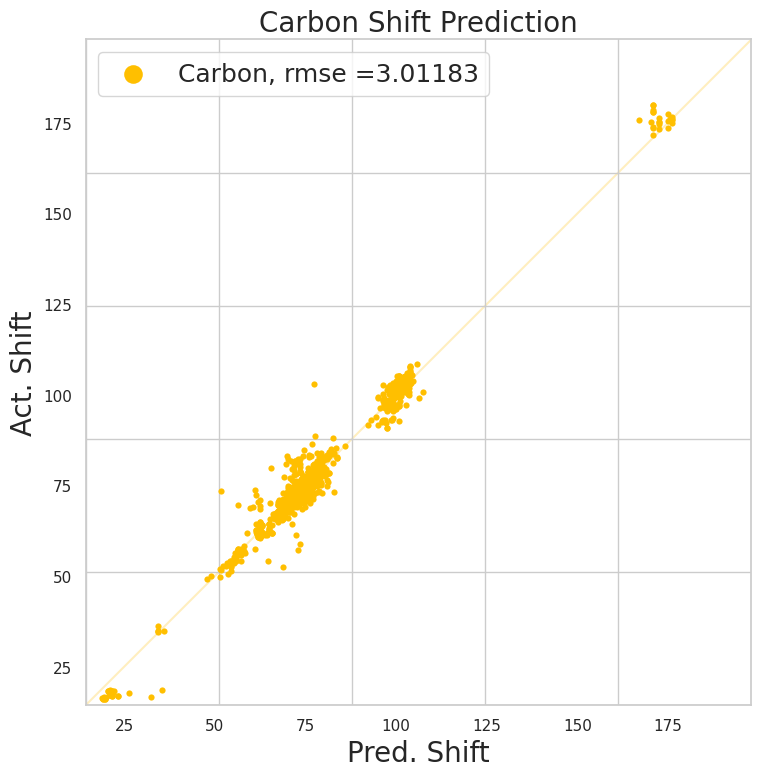

In [26]:
sns.set_theme(style="whitegrid", font_scale=1)

figure, axis = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=False)
# figure, axis = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=False)
# figure, axis = plt.subplots(3, 3, figsize=(8, 8))
figure.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad = 1, w_pad = 1)
##### For node features

plot_shift(df_visulize_v3, axis, i = 0, set_title_name = 'Carbon Shift Prediction', sep = 5, xlab_name = 'Pred. Shift', 
           ylab_name = 'Act. Shift', color = '#FFBF00', ms = 5)
# plot_shift(df_visulize_v2, axis, i = 0, set_title_name = 'Hydrogen shift prediction all type', sep = 5, xlab_name = 'Pred. Shift', 
#            ylab_name = 'Act. Shift', color = '#679399', ms = 5)

plt.show()

In [27]:
data_dir = 'experimental_data_combined/FullyAnnotatedPDB_pdb_labeled_combined_add_temperature_reformulate_pdb_outlier_removal_second_round/'
files_labels_list = os.listdir(data_dir)

##### Extract glycan name, atom type 

In [28]:
test_index, len(files_labels_list)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 

In [29]:
atom_test_list = []
atom_name_test_list = []
hydrogen_list_1_6 = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H61', 'H62']
carbon_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6'] + ['C1_KDO', 'C2_KDO', 'C3_KDO', 'C4_KDO', 'C5_KDO', 'C6_KDO', 'C7_KDO', 'C8_KDO']
for i in range(len(files_labels_list)):
#     if test_index[i]:
    if not test_index[i]:
        temp_df = pd.read_csv(os.path.join(data_dir, files_labels_list[i]))
    
    
        temp_atom_list = list(temp_df.loc[(temp_df['labels'] !=-1)]['Atom_Type'].values)
        
        temp_atom_list_hydrogen = [i for i in temp_atom_list if i in hydrogen_list_1_6]
        atom_test_list.extend(temp_atom_list_hydrogen)
        
        atom_name_test_list.extend(np.repeat(files_labels_list[i], len(temp_atom_list_hydrogen)))
        
#         temp_atom_list = list(temp_df.loc[(temp_df['labels'] !=-1) & ((temp_df['labels'] > 10))]['Atom_Type'].values)
#         temp_atom_list_carbon = [i for i in temp_atom_list if i in carbon_list]
#         atom_test_list.extend(temp_atom_list_carbon)
        
        
#         atom_name_test_list.extend(np.repeat(files_labels_list[i], len(temp_atom_list_carbon)))

In [30]:
# df_visulize

In [31]:
# df_visulize['atom_type'] = atom_test_list
# df_visulize['glycan_name'] = atom_name_test_list
# df_visulize['difference'] = np.abs(df_visulize['1'] - df_visulize['0'])


In [32]:
# df_visulize_outlier = df_visulize.loc[np.abs(df_visulize['0'].values - df_visulize['1'].values) > 0.3]
# df_visulize_outlier.index = range(len(df_visulize_outlier))
# df_visulize_outlier['difference'] = np.abs(df_visulize_outlier['1'] - df_visulize_outlier['0'])

In [33]:
# outlier_glycan = np.unique(df_visulize_outlier['glycan_name'].values)

In [34]:
# for j in outlier_glycan:
#     if j in os.listdir('experimental_data_combined/kdo_relabeled_correct/'):
#         print(j)

In [35]:
# df_visulize = df_visulize.sort_values(by = ['glycan_name'])
# df_visulize.index = range(len(df_visulize))

In [36]:
# df_visulize_outlier = df_visulize_outlier.sort_values(by = ['glycan_name'])
# df_visulize_outlier.index = range(len(df_visulize_outlier))

In [37]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_hydrogen_training.csv', 
#                    index = False)

# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_hydrogen.csv', 
#                    index = False)

# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_carbon.csv', 
#                    index = False)


# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_carbon_training.csv', 
#                    index = False)

In [38]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/second_round/with_kdo_labeled_results_all_carbon_test.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/second_round/with_kdo_labeled_results_all_carbon_test_outlier.csv', 
#                    index = False)


In [39]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/second_round/with_kdo_labeled_results_all_carbon_train.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/second_round/with_kdo_labeled_results_all_carbon_train_outlier.csv', 
#                    index = False)

In [40]:
len(df_visulize)

1247

In [41]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/second_round_without_kdo/without_kdo_labeled_results_all_carbon_test.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/second_round_without_kdo/without_kdo_labeled_results_all_carbon_test_outlier.csv', 
#                    index = False)



In [42]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/second_round_without_kdo/without_kdo_labeled_results_all_carbon_train.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/second_round_without_kdo/without_kdo_labeled_results_all_carbon_train_outlier.csv', 
#                    index = False)

In [43]:
# df_visulize_outlier.sort_values(by= ['difference'], ignore_index=True)

In [44]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/third_round/with_kdo_labeled_results_all_carbon_test.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/third_round/with_kdo_labeled_results_all_carbon_test_outlier.csv', 
#                    index = False)



In [45]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/third_round/with_kdo_labeled_results_all_carbon_train.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/third_round/with_kdo_labeled_results_all_carbon_train_outlier.csv', 
#                    index = False)

In [46]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/third_round/hydrogenwith_kdo_labeled_results_all_carbon_test.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/third_round/hydrogenwith_kdo_labeled_results_all_carbon_test_outlier.csv', 
#                    index = False)

In [47]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/third_round/hydrogenwith_kdo_labeled_results_all_carbon_train.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/third_round/hydrogenwith_kdo_labeled_results_all_carbon_train_outlier.csv', 
#                    index = False)